## Valorant Game: Providing Data Analysis for Players.

### Description and deliverables

This project is a personal analysis of Valorant player data for myself and my friends.

Valorant is a 5v5 tactical shooter where teams alternate between attacking and defending. Attackers plant a bomb ("spike") while defenders try to stop them or defuse it. The first team to win 13 rounds wins the match, unless both teams reach 12 rounds, triggering overtime. In overtime, teams alternate between attack and defense for one round each. A team needs to win by two rounds to secure victory. Each team starts with a set amount of credits in overtime.

This project is for my friends and me. We each have different playing styles—some aggressive, some more passive—which makes coaching each other difficult since our execution methods differ. The goal is to use a data-driven approach to identify universal indicators for victory to increase all of our win rates.

Data source: The data comes from a website called tracker.gg. While Riot’s API isn’t publicly available, some partners have access. I had to learn web scraping techniques because the website has anti-scraping measures. Since the data likely comes from the API, it is well-formatted, requiring minimal cleaning. There were some NaN values in the "Clutches" and "Abilities" columns, but they were handled easily.

At this stage, I'm evaluating the subjectivity of the data and whether it's necessary to gather data from other sources.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
## data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## metrics & functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

import pickle

### Data Exploration

Understanding each varibles, Cleaning data, dealing with outliers




In [2]:
df0 = pd.read_csv('Valorant_Matches_ALL.csv')

df0.head()

Date Match Result Map Name      Rank       alias Agent Name  \
0  2020-07-05 16:55:33      victory    Haven  Silver 3  sp1cyn00dz       Sova   
1  2020-07-11 18:09:27         tied    Split  Silver 3  sp1cyn00dz       Sova   
2  2020-07-13 17:37:42      victory    Split    Gold 2       shift      Reyna   
3  2020-07-17 13:53:38       defeat    Split  Silver 3  sp1cyn00dz       Sova   
4  2020-07-21 16:06:02       defeat     Bind  Silver 3  sp1cyn00dz       Sova   

   Sum of Match Result Binary  Sum of Kills  Sum of Deaths  \
0                         1.0            21             13   
1                         0.5            12             20   
2                         1.0             8             10   
3                         0.0             9              7   
4                         0.0             7              9   

   Sum of Headshots Percentage  ...  Sum of Econ Rating  Sum of Clutches  \
0                    13.253012  ...                  97                1   
1                    14.545455  ...                  35                1   
2                    14.285714  ...                  37                3   
3                     7.692308  ...                  58                0   
4                    24.000000  ...                  43                0   

   Sum of Round Ratio  Sum of Rounds Lost  Sum of Rounds Played  \
0            1.625000                   8                    21   
1            1.000000                  14                    29   
2            3.250000                   4                    17   
3            0.857143                  14                    26   
4            0.384615                  13                    13   

   Sum of Rounds Won  Sum of Team Aces  Sum of Thrifty  Sum of Traded  \
0                 13                10               5              0   
1                 14                 7               5              1   
2                 13                 4               3              0   
3                 12                 2               8              1   
4                  5                 5               4              0   

   Sum of TRN Performance Score  
0                           860  
1                           278  
2                           425  
3                           293  
4                           267  

[5 rows x 40 columns]

In [6]:
df0.describe

<bound method NDFrame.describe of                      Date Match Result Map Name        Rank       alias  \
0     2020-07-05 16:55:33      victory    Haven    Silver 3  sp1cyn00dz   
1     2020-07-11 18:09:27         tied    Split    Silver 3  sp1cyn00dz   
2     2020-07-13 17:37:42      victory    Split      Gold 2       shift   
3     2020-07-17 13:53:38       defeat    Split    Silver 3  sp1cyn00dz   
4     2020-07-21 16:06:02       defeat     Bind    Silver 3  sp1cyn00dz   
...                   ...          ...      ...         ...         ...   
6228  2024-09-20 20:36:12       defeat    Lotus  Platinum 3      silver   
6229  2024-09-20 21:09:42       defeat   Sunset  Platinum 3      silver   
6230  2024-09-20 21:55:52       defeat     Bind  Platinum 2      silver   
6231  2024-09-20 22:46:47      victory   Sunset  Platinum 2      silver   
6232  2024-09-22 19:19:23      victory    Abyss  Platinum 2      silver   

     Agent Name  Sum of Match Result Binary  Sum of Kills  Sum of

In [7]:
df0.info(38)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6233 entries, 0 to 6232
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           6233 non-null   object 
 1   Match Result                   6233 non-null   object 
 2   Map Name                       6233 non-null   object 
 3   Rank                           6233 non-null   object 
 4   alias                          6233 non-null   object 
 5   Agent Name                     6233 non-null   object 
 6   Sum of Match Result Binary     6233 non-null   float64
 7   Sum of Kills                   6233 non-null   int64  
 8   Sum of Deaths                  6233 non-null   int64  
 9   Sum of Headshots Percentage    6233 non-null   float64
 10  Sum of Headshots               6233 non-null   int64  
 11  Sum of Assists                 6233 non-null   int64  
 12  Sum of Damage                  6233 non-null   i

## Renaming columns

Initially, the project only involved my data. After scraping my friends' data, it was loaded into Power BI and then re-exported after combining all players. The transformation added "Sum" to the column titles, which had to be removed. Also removing spaces and added _ for best practices

In [3]:
df0.columns = df0.columns.str.replace('Sum of ', '')
df0.head()

Date Match Result Map Name      Rank       alias Agent Name  \
0  2020-07-05 16:55:33      victory    Haven  Silver 3  sp1cyn00dz       Sova   
1  2020-07-11 18:09:27         tied    Split  Silver 3  sp1cyn00dz       Sova   
2  2020-07-13 17:37:42      victory    Split    Gold 2       shift      Reyna   
3  2020-07-17 13:53:38       defeat    Split  Silver 3  sp1cyn00dz       Sova   
4  2020-07-21 16:06:02       defeat     Bind  Silver 3  sp1cyn00dz       Sova   

   Match Result Binary  Kills  Deaths  Headshots Percentage  ...  Econ Rating  \
0                  1.0     21      13             13.253012  ...           97   
1                  0.5     12      20             14.545455  ...           35   
2                  1.0      8      10             14.285714  ...           37   
3                  0.0      9       7              7.692308  ...           58   
4                  0.0      7       9             24.000000  ...           43   

   Clutches  Round Ratio  Rounds Lost  Rounds Played  Rounds Won  Team Aces  \
0         1     1.625000            8             21          13         10   
1         1     1.000000           14             29          14          7   
2         3     3.250000            4             17          13          4   
3         0     0.857143           14             26          12          2   
4         0     0.384615           13             13           5          5   

   Thrifty  Traded  TRN Performance Score  
0        5       0                    860  
1        5       1                    278  
2        3       0                    425  
3        8       1                    293  
4        4       0                    267  

[5 rows x 40 columns]

In [4]:
df0.columns = df0.columns.str.replace(' ', '_')
df0.head()

Date Match_Result Map_Name      Rank       alias Agent_Name  \
0  2020-07-05 16:55:33      victory    Haven  Silver 3  sp1cyn00dz       Sova   
1  2020-07-11 18:09:27         tied    Split  Silver 3  sp1cyn00dz       Sova   
2  2020-07-13 17:37:42      victory    Split    Gold 2       shift      Reyna   
3  2020-07-17 13:53:38       defeat    Split  Silver 3  sp1cyn00dz       Sova   
4  2020-07-21 16:06:02       defeat     Bind  Silver 3  sp1cyn00dz       Sova   

   Match_Result_Binary  Kills  Deaths  Headshots_Percentage  ...  Econ_Rating  \
0                  1.0     21      13             13.253012  ...           97   
1                  0.5     12      20             14.545455  ...           35   
2                  1.0      8      10             14.285714  ...           37   
3                  0.0      9       7              7.692308  ...           58   
4                  0.0      7       9             24.000000  ...           43   

   Clutches  Round_Ratio  Rounds_Lost  Rounds_Played  Rounds_Won  Team_Aces  \
0         1     1.625000            8             21          13         10   
1         1     1.000000           14             29          14          7   
2         3     3.250000            4             17          13          4   
3         0     0.857143           14             26          12          2   
4         0     0.384615           13             13           5          5   

   Thrifty  Traded  TRN_Performance_Score  
0        5       0                    860  
1        5       1                    278  
2        3       0                    425  
3        8       1                    293  
4        4       0                    267  

[5 rows x 40 columns]

In [5]:
df0['Clutches'] = df0['Clutches'].fillna(0)
df0['Clutches'].describe()

count    6233.000000
mean        0.521739
std         0.767532
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: Clutches, dtype: float64

In [6]:
df0.isna().sum()

Date                        0
Match_Result                0
Map_Name                    0
Rank                        0
alias                       0
Agent_Name                  0
Match_Result_Binary         0
Kills                       0
Deaths                      0
Headshots_Percentage        0
Headshots                   0
Assists                     0
Damage                      0
Damage_Delta_Per_Round      0
Damage_Per_Round            0
Damage_Received             0
Dealt_Bodyshots             0
Dealt_Headshots             0
First_Bloods                0
First_Deaths                0
KD_Ratio                    0
KAST                        0
Grenade_Casts             188
Ability_1_Casts           188
Ability_2_Casts           188
Ultimate_Casts            188
Plants                      0
Last_Deaths                 0
Flawless                    0
Defuses                     0
Econ_Rating                 0
Clutches                    0
Round_Ratio                 0
Rounds_Los

In [7]:
df0[['Ability_1_Casts', 'Ability_2_Casts', 'Ultimate_Casts', 'Grenade_Casts']] = df0[['Ability_1_Casts', 'Ability_2_Casts', 'Ultimate_Casts', 'Grenade_Casts']].fillna(0)

df0.isna().sum()

Date                      0
Match_Result              0
Map_Name                  0
Rank                      0
alias                     0
Agent_Name                0
Match_Result_Binary       0
Kills                     0
Deaths                    0
Headshots_Percentage      0
Headshots                 0
Assists                   0
Damage                    0
Damage_Delta_Per_Round    0
Damage_Per_Round          0
Damage_Received           0
Dealt_Bodyshots           0
Dealt_Headshots           0
First_Bloods              0
First_Deaths              0
KD_Ratio                  0
KAST                      0
Grenade_Casts             0
Ability_1_Casts           0
Ability_2_Casts           0
Ultimate_Casts            0
Plants                    0
Last_Deaths               0
Flawless                  0
Defuses                   0
Econ_Rating               0
Clutches                  0
Round_Ratio               0
Rounds_Lost               0
Rounds_Played             0
Rounds_Won          

In [8]:
df0.duplicated().sum()

np.int64(0)

### Adding Victory Varible

Transforming the match result column into a binary victory state for easier ML modeling, with tied games combined as defeats. Tied games are a small percentage and complicate modeling. The ethical concern of removing ties is minimal since they are on the edge of victory and defeat. The goal is to find universal indicators for victory. Additionally, ties neither reward nor punish players in the MMR system, making them a wash.

In [9]:
df0['Victory'] = df0['Match_Result'].replace({'victory': 1, 'defeat': 0, 'tied': 0})
df0['Victory']

C:\Users\justs\AppData\Local\Temp\ipykernel_17204\1639858904.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df0['Match_Result_Binary'] = df0['Match_Result'].replace({'victory': 1, 'defeat': 0, 'tied': 0})


0       1
1       0
2       1
3       0
4       0
       ..
6228    0
6229    0
6230    0
6231    1
6232    1
Name: Match_Result_Binary, Length: 6233, dtype: int64

### Detecting outliers

Breakout performances are common in Valorant, often due to exploiting the other team's strategy or a player's skill mismatch. Identifying these instances in the dataset is crucial for accurate modeling.

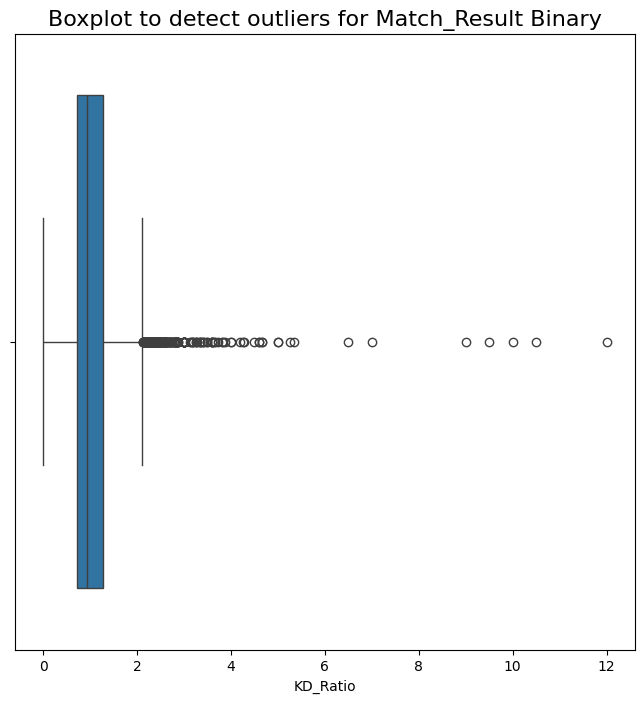

In [15]:
#detect outliers for KD raitos

plt.figure(figsize=(8,8))
plt.title('Boxplot to detect outliers for Match_Result Binary', fontsize=16)
sns.boxplot(x=df0['KD_Ratio'])
plt.show()

### Removing outliers


The Interquartile Range (IQR) measures statistical spread by calculating the range between the 1st quartile (Q1, 25th percentile) and the 3rd quartile (Q3, 75th percentile).

In [10]:

# Function to set IQR limits
def set_iqr_limits(column):
    Q1 = df0[column].quantile(0.25)
    Q3 = df0[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return lower_limit, upper_limit

# Calculate outlier limits and mark outliers
for column in ['KD_Ratio', 'Damage_Per_Round', 'Damage_Delta_Per_Round', 'Rounds_Played']:
    lower, upper = set_iqr_limits(column)
    df0[f'{column}_is_outlier'] = (df0[column] < lower) | (df0[column] > upper)
    print(f"{column}:")
    print(f"  Lower Outlier Limit: {lower}")
    print(f"  Upper Outlier Limit: {upper}")
    print()

# Create a new DataFrame without outliers
# Filter the DataFrame where none of the outlier flags are True
outlier_columns = [f'{column}_is_outlier' for column in ['KD_Ratio', 'Damage_Per_Round', 'Damage_Delta_Per_Round', 'Rounds_Played']]
df1 = df0[~df0[outlier_columns].any(axis=1)]

KD_Ratio:
  Lower Outlier Limit: -0.13095238095238082
  Upper Outlier Limit: 2.1230158730158726

Damage_Per_Round:
  Lower Outlier Limit: 31.9473684210526
  Upper Outlier Limit: 231.02105263157898

Damage_Delta_Per_Round:
  Lower Outlier Limit: -118.70108695652175
  Upper Outlier Limit: 113.16847826086958

Rounds_Played:
  Lower Outlier Limit: 13.0
  Upper Outlier Limit: 29.0



In [17]:
# set limits for outliers

def set_iqr_limits(column):
    Q1 = df0[column].quantile(0.25)
    Q3 = df0[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return lower_limit, upper_limit

outliers = pd.DataFrame()

# Calculate outlier limits for each column
for column in ['KD_Ratio', 'Damage_Per_Round', 'Damage_Delta_Per_Round', 'Rounds_Played',]:
    lower, upper = set_iqr_limits(column)
    print(f"{column}:")
    print(f"  Lower Outlier Limit: {lower}")
    print(f"  Upper Outlier Limit: {upper}")
    print()
        # Subset of data containing outliers in the current column
    outlier = df0[(df0[column] > upper) | (df0[column] < lower)]
    
    # Append the outliers to the 'outliers' DataFrame
    outliers = pd.concat([outliers, outlier_subset])
    # Optionally, mark or filter outliers
    df0[f'{column}_is_outlier'] = (df0[column] < lower) | (df0[column] > upper)


KD_Ratio:
  Lower Outlier Limit: -0.13095238095238082
  Upper Outlier Limit: 2.1230158730158726



NameError: name 'outlier_subset' is not defined

### Checking Match Result Destubution

Understanding the distribution allows for better preprocessing, such as applying transformations or adjusting for imbalanced classes.

In [11]:
print(df0['Match_Result_Binary'].value_counts())

## Get percentages of people who'Match_Result_Binary vs. stayed

print()
print(df0['Match_Result_Binary'].value_counts(normalize=True))

Match_Result_Binary
0    3161
1    3072
Name: count, dtype: int64

Match_Result_Binary
0    0.507139
1    0.492861
Name: proportion, dtype: float64


## pAce: Analysis Stage
- perform EDA 


### Looking for relationships between Varibles

Looking for relationships between variables in machine learning modeling is crucial because it helps identify correlations, patterns, or dependencies that can improve predictive accuracy.

KD_ratio is a good varible to messure the players performace in the game. Although not perfect, it messures the players ability to win fights before getting traded by the opposing team. 


### Created Varibles 

Date and Time
- Seperating Date and Time 

Utility usage. 
- This combined grenade, ability cast 1, ability cast 2, and ultimate cast

Traded (name Varible)
- low med or high



### Using Boxplot to detect skewness and variability. following is a table of the data visualiztions
- KD_Ratio vs Victory
- Damange Delta vs Kills
- Kills vs Ultimate Casts
- Utility Usage vs KD_Ratio
- Utility Usage vs KD_Ratio for different ranks
- Utility Usage vs KD_Ratio for different players
- Traded vs Kills
- Kills vs Clutches
- Rounds won by Last Deaths


##### KD_Ratio vs Rounds played

looking for a relationship between game lenth and performace of player in match



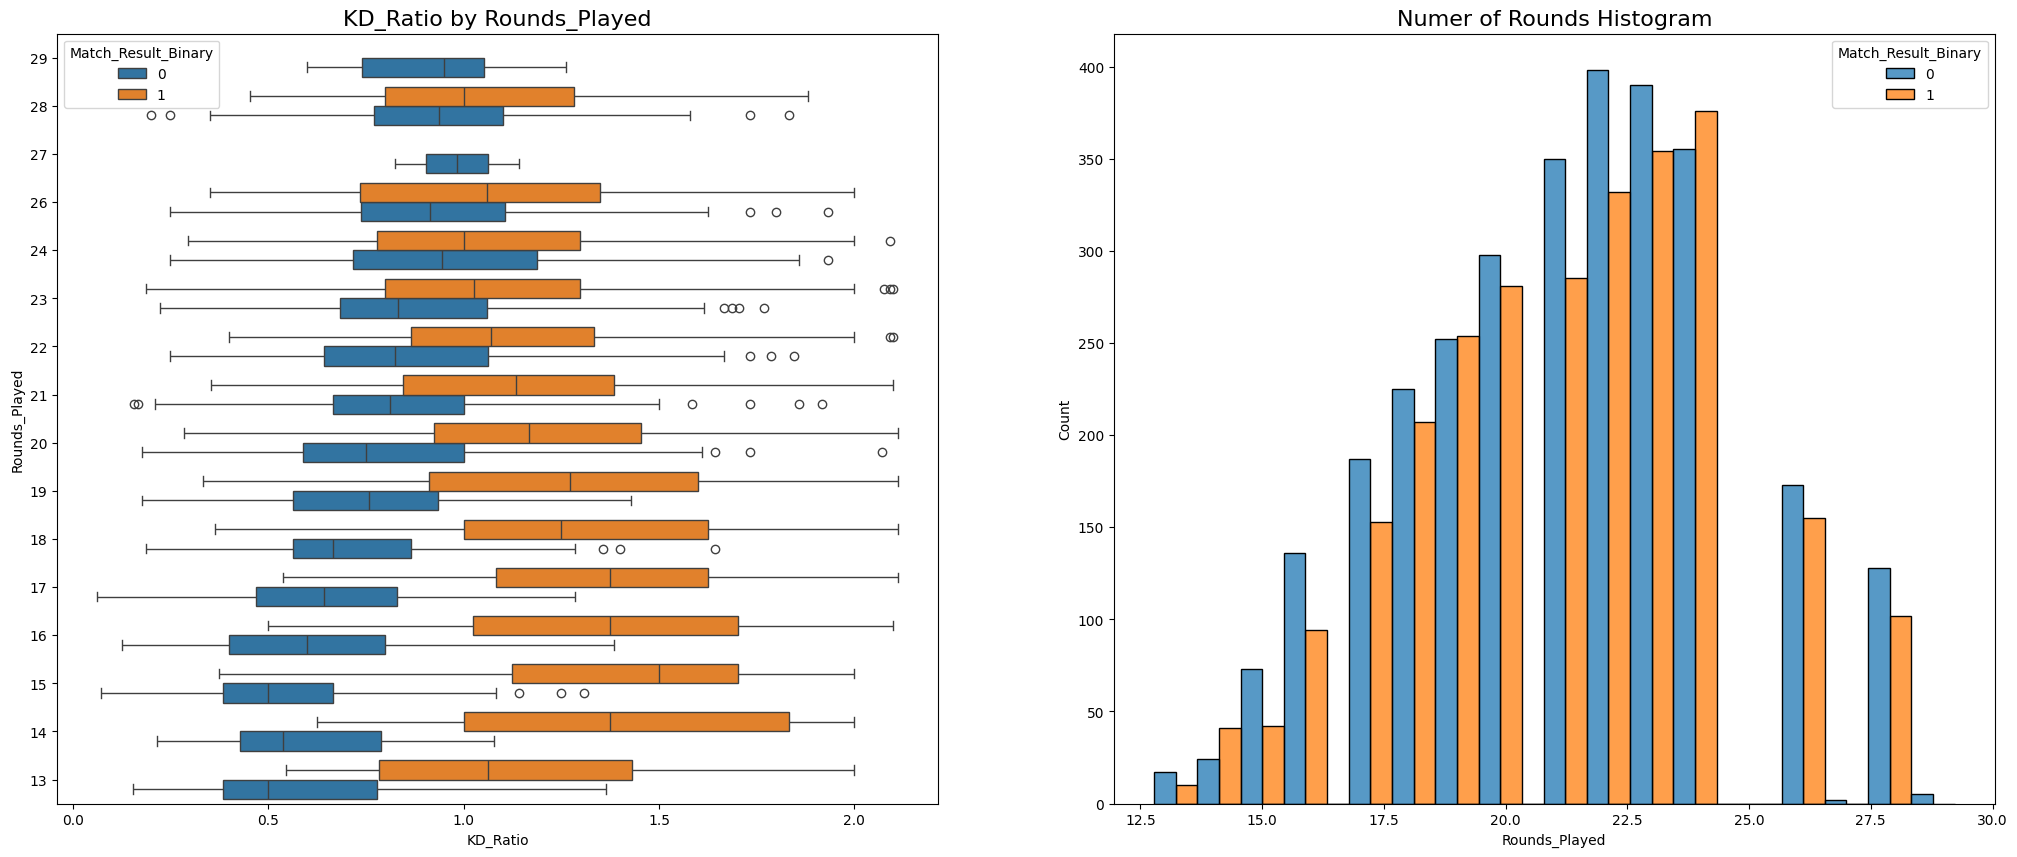

In [174]:
## create box plot and histogram

## set figues and axes
fig, ax = plt.subplots(1, 2, figsize = (25,10))

## create boxplot comparing Players those who Won Match vs Match_Result_Binary from'KD_Ratio' distrubutions for 'Rounds_Played'
sns.boxplot(data=df1, x='KD_Ratio', y='Rounds_Played', hue='Match_Result_Binary', orient='h', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('KD_Ratio by Rounds_Played', fontsize='16')

## create histogram comparing Players those who Won Match vs Match_Result_Binary from 'Rounds_Played'
roundsplayed_victory = df1[df1['Match_Result_Binary']==0]['Rounds_Played']
roundsplayed_defeat = df1[df1['Match_Result_Binary']==1]['Rounds_Played']
sns.histplot(data=df1, x='Rounds_Played', hue='Match_Result_Binary', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Numer of Rounds Histogram', fontsize='16')

plt.show()

These graphs show the longer the game goes lower the avgerage KD_ratio. We can see a seperation in high KD_Ratios have higher chances of victories and lower KD_ratios lead to defeat.

In [12]:
average_kd_ratio = df1['KD_Ratio'].mean()
print(average_kd_ratio)

0.9816407533879327


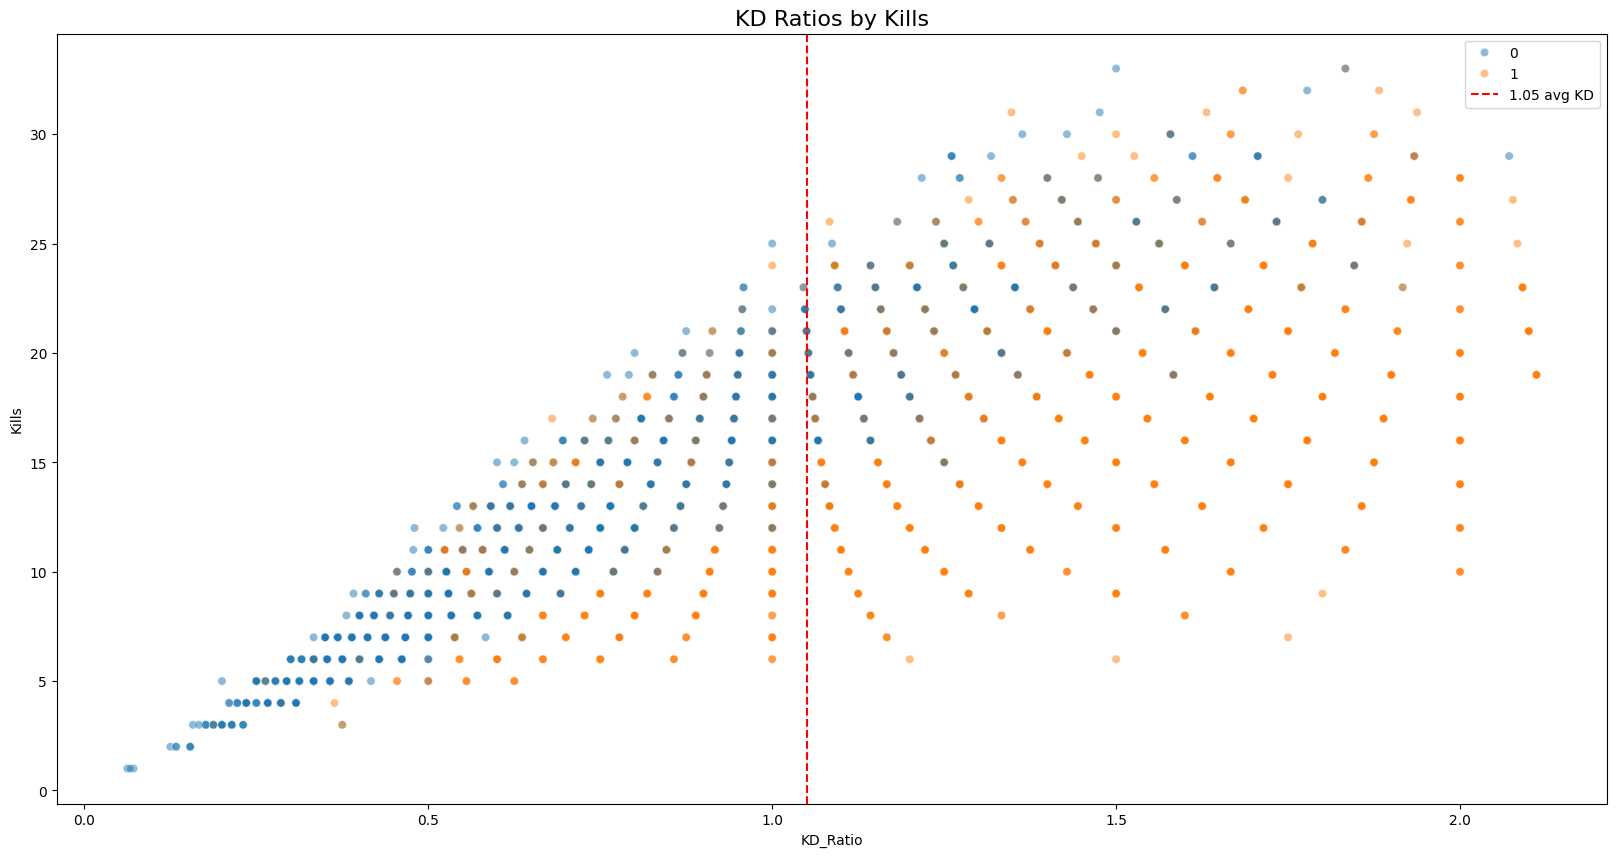

In [137]:
## create scatter plot of KD Ratio vs Kills comparing stayed vs'Match_Result_Binary
plt.figure(figsize=(20,10))
sns.scatterplot(data=df1, x='KD_Ratio', y='Kills', hue='Match_Result_Binary', alpha=0.5)
plt.axvline(x=1.05, color='red', label='1.05 avg KD', ls='--')
plt.legend()
plt.title('KD Ratios by Kills', fontsize='16');

the dot plot is confirming the higher the KD_ratio beyond the average has more victories. It also shows more kills does guarantee victory conditions 

In [138]:
average_Damage_Delta_Per_Round = df1['Damage_Delta_Per_Round'].mean()
print(average_Damage_Delta_Per_Round)

-5.696649577512372


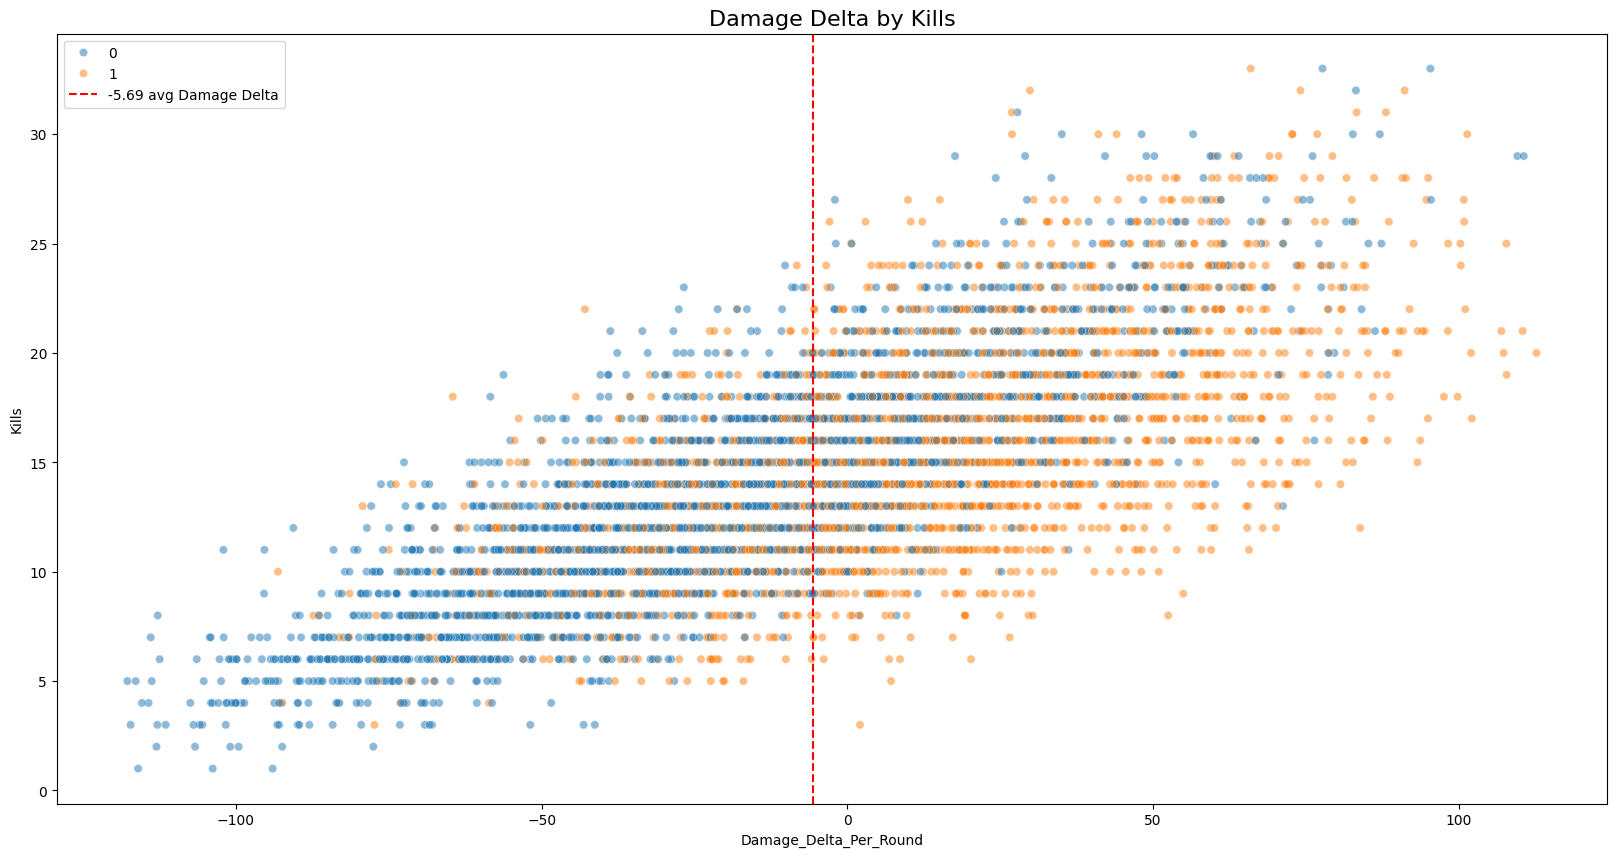

In [139]:
## create scatter plot of avg monthly hours vs satisfaction levels comparing stayed vs'Match_Result_Binary
plt.figure(figsize=(20,10))
sns.scatterplot(data=df1, x='Damage_Delta_Per_Round', y='Kills', hue='Match_Result_Binary', alpha=0.5)
plt.axvline(x=-5.69, color='red', label='-5.69 avg Damage Delta', ls='--')
plt.legend()
plt.title('Damage Delta by Kills', fontsize='16');

attempting to see if the same patter happens with Damage delta per round similar patter is created

In [140]:
average_Kills = df1['Kills'].mean()
print(average_Kills)

14.344446394104228


In [141]:
average_Ultimate_Casts = df1['Ultimate_Casts'].mean()
print(average_Ultimate_Casts)

2.3905948412002105


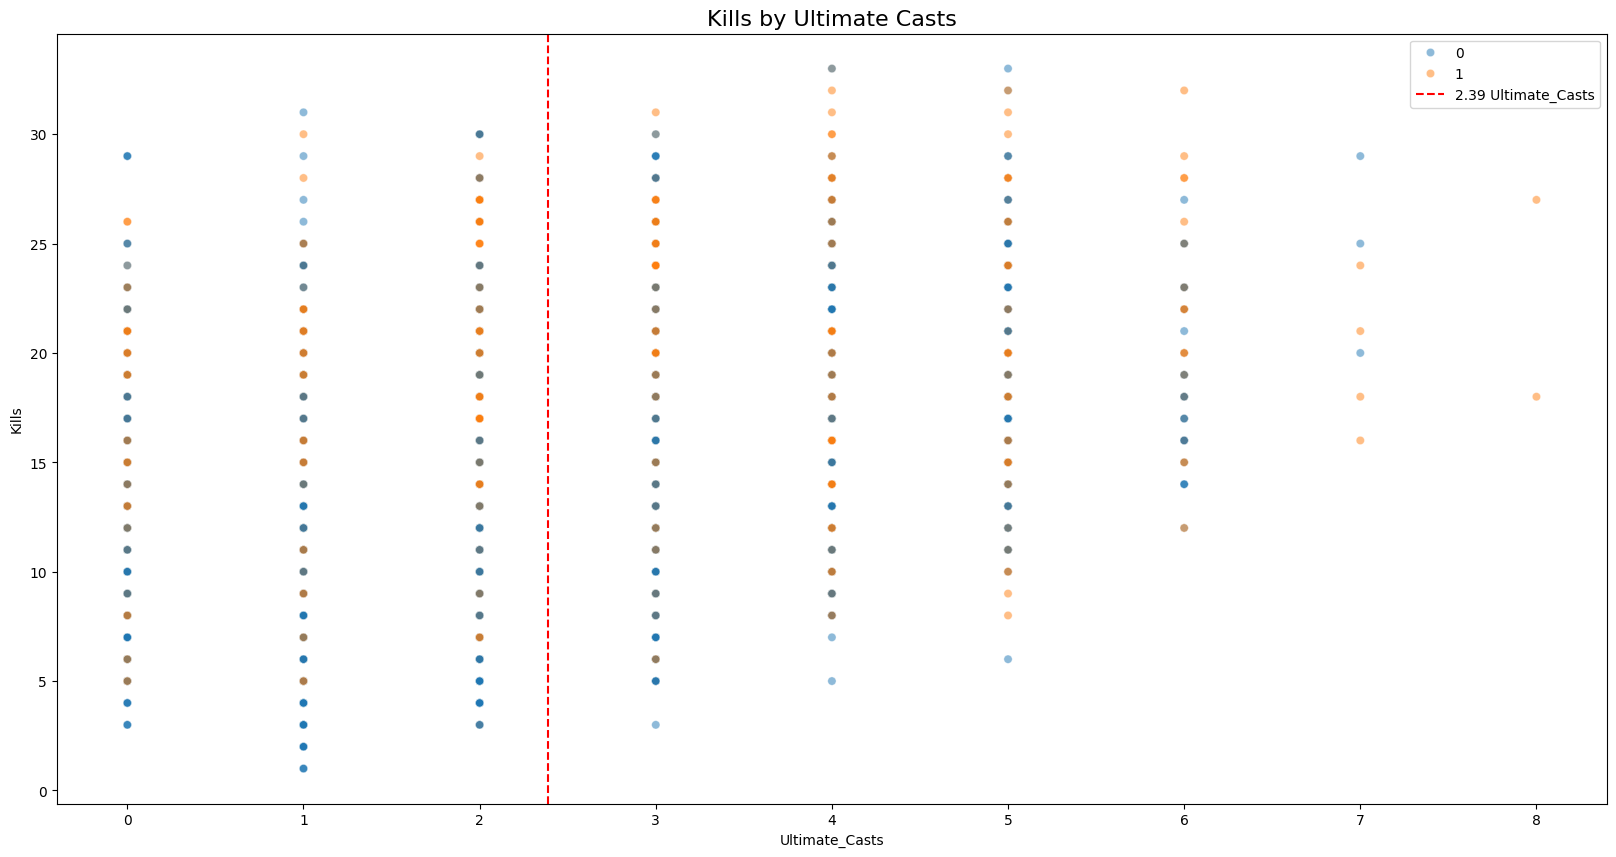

In [142]:
## create scatter plot of avg monthly hours vs satisfaction levels comparing stayed vs'Match_Result_Binary
plt.figure(figsize=(20,10))
sns.scatterplot(data=df1, x='Ultimate_Casts', y='Kills', hue='Match_Result_Binary', alpha=0.5)
plt.axvline(x=2.39, color='red', label='2.39 Ultimate_Casts', ls='--')
plt.legend()
plt.title('Kills by Ultimate Casts', fontsize='16');

Because ultimates sometimes can guarantee, looking into a correlation with ultimate use and the amount of kills a play can get per game

In [28]:
df1['Utility_Usage'] = df1['Grenade_Casts'] + df1['Ability_1_Casts'] + df1['Ability_2_Casts']
df1['Utility_Usage']

C:\Users\justs\AppData\Local\Temp\ipykernel_19756\1320567177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Utility_Usage'] = df1['Grenade_Casts'] + df1['Ability_1_Casts'] + df1['Ability_2_Casts']


0       31.0
1        0.0
2       33.0
3       21.0
4        0.0
        ... 
6227    68.0
6228    32.0
6229    53.0
6230    63.0
6232    59.0
Name: Utility_Usage, Length: 5699, dtype: float64

Created a varible utility_usage to see if there is a corralation with utility_usage and getting kills or surviving engagements 

In [29]:
average_Utility_Usage = df1['Utility_Usage'].mean()
print(average_Utility_Usage)

42.746797683804175


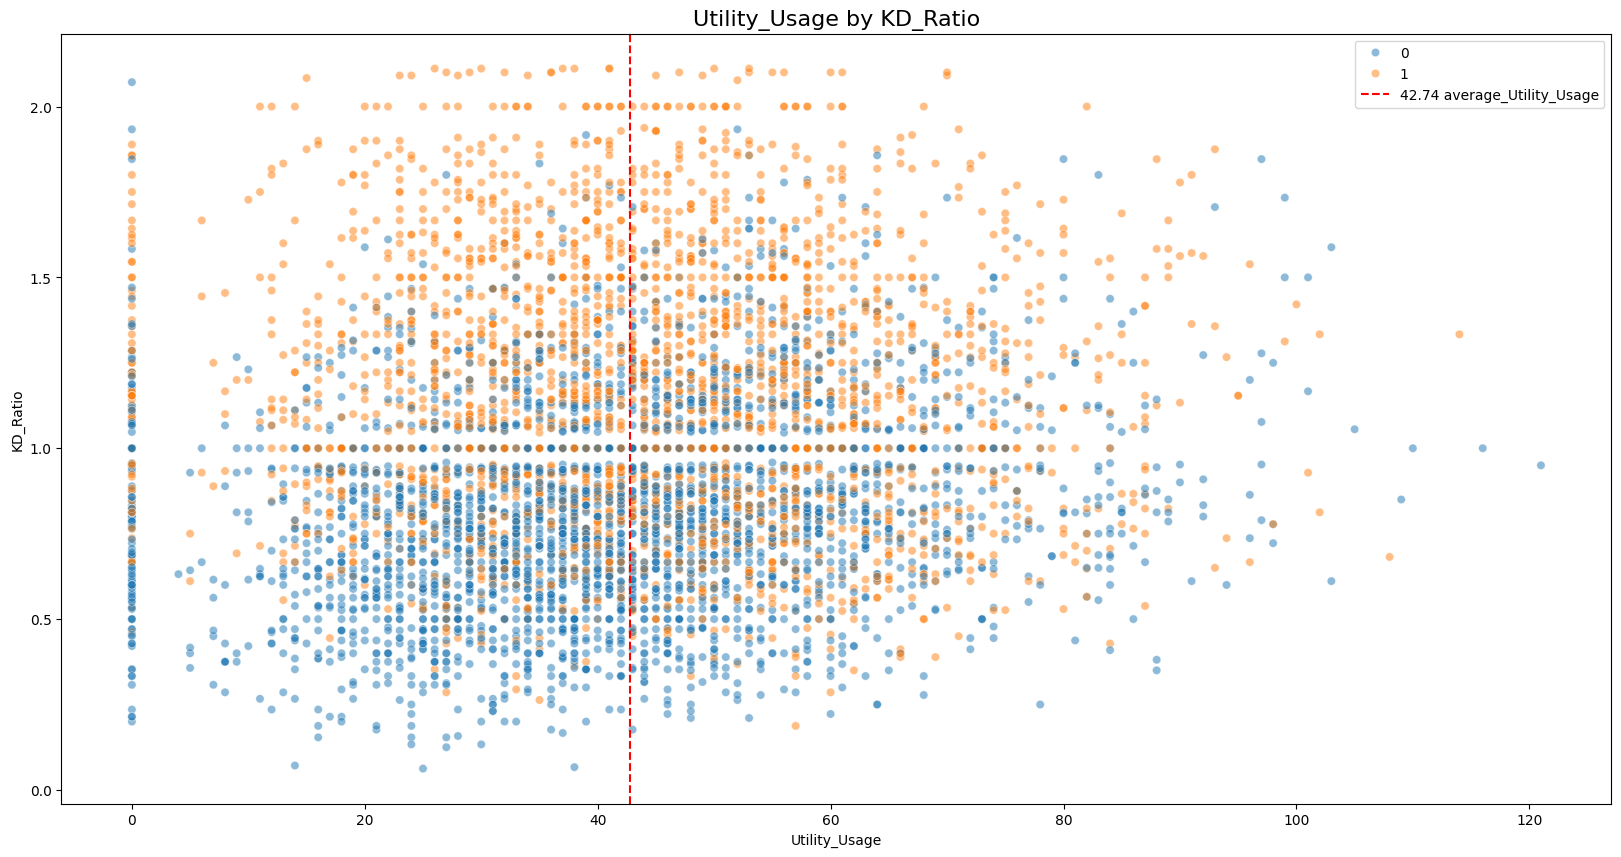

In [145]:
## create scatter plot of avg monthly hours vs satisfaction levels comparing stayed vs'Match_Result_Binary
plt.figure(figsize=(20,10))
sns.scatterplot(data=df1, x='Utility_Usage', y='KD_Ratio', hue='Match_Result_Binary', alpha=0.5)
plt.axvline(x=42.74, color='red', label='42.74 average_Utility_Usage', ls='--')
plt.legend()
plt.title('Utility_Usage by KD_Ratio', fontsize='16');

it is unclear of a correlation between the two varibles. lets see what the patters look like between the ranks

### Creating data set for Games at ranks

analysis of different ranks in the data set

In [150]:
df_goldplayers = df1[df1['Rank'].isin(['Gold 1', 'Gold 2', 'Gold 3'])]

In [151]:
average_Gold_Utility_Usage = df_goldplayers['Utility_Usage'].mean()
print(average_Gold_Utility_Usage)

36.418013856812934


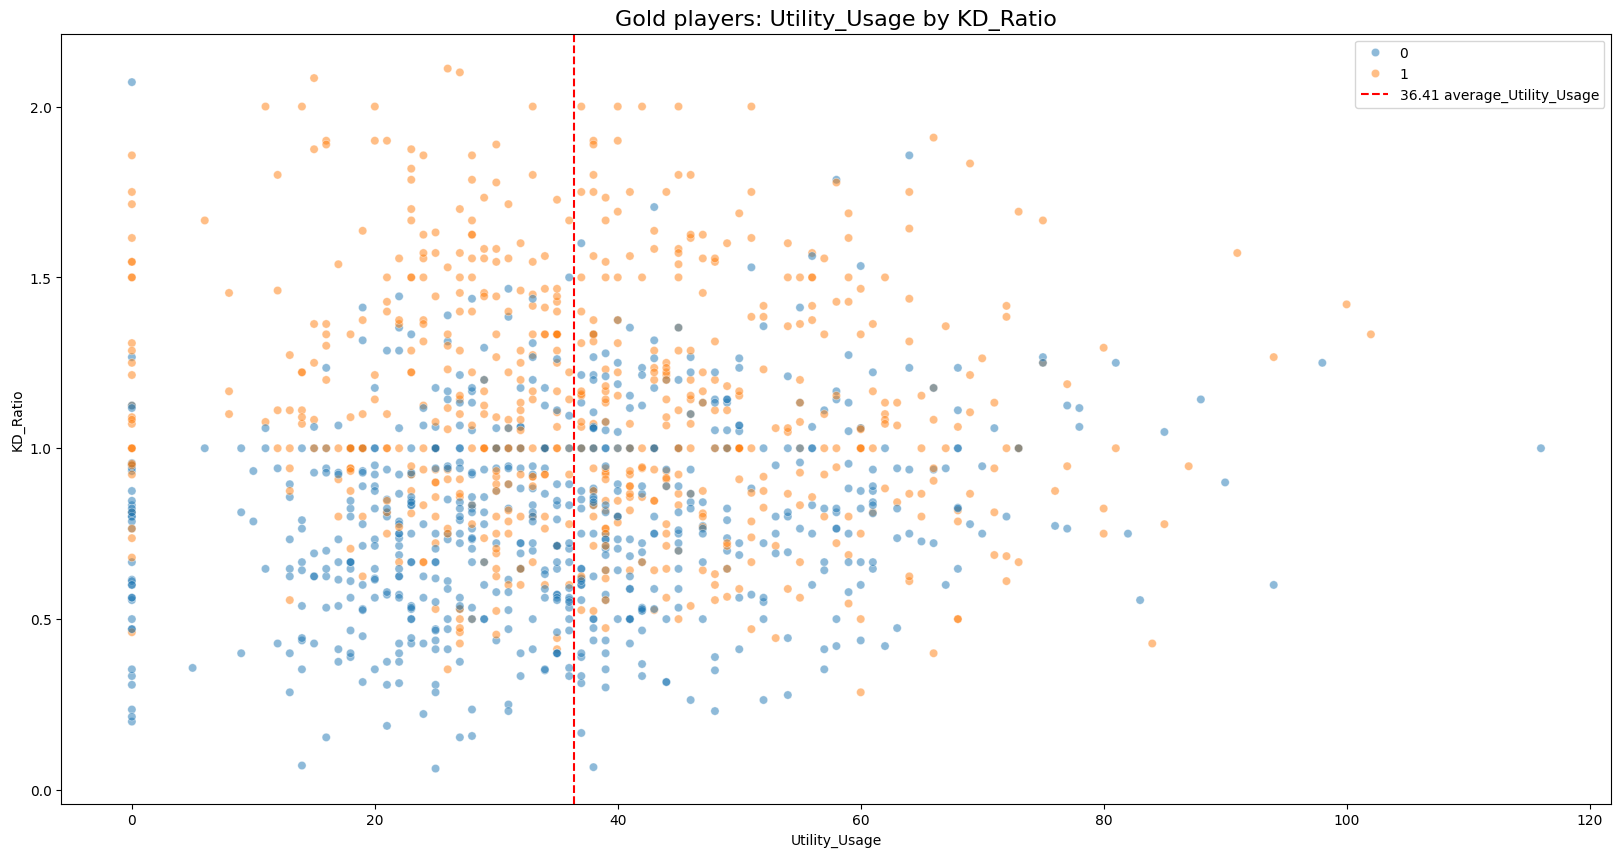

In [152]:
## create scatter plot of avg monthly hours vs satisfaction levels comparing stayed vs'Match_Result_Binary
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_goldplayers, x='Utility_Usage', y='KD_Ratio', hue='Match_Result_Binary', alpha=0.5)
plt.axvline(x=36.41, color='red', label='36.41 average_Utility_Usage', ls='--')
plt.legend()
plt.title('Gold players: Utility_Usage by KD_Ratio', fontsize='16');

Gold players seem to have a lower avgerage and some quiet a few games with no util used during the game. the patter seems to be left skewed

In [153]:
df_platinumplayers = df1[df1['Rank'].isin(['Platinum 1', 'Platinum 2', 'Platinum 3'])]

In [154]:
average_platinum_Utility_Usage = df_platinumplayers['Utility_Usage'].mean()
print(average_platinum_Utility_Usage)

47.978142076502735


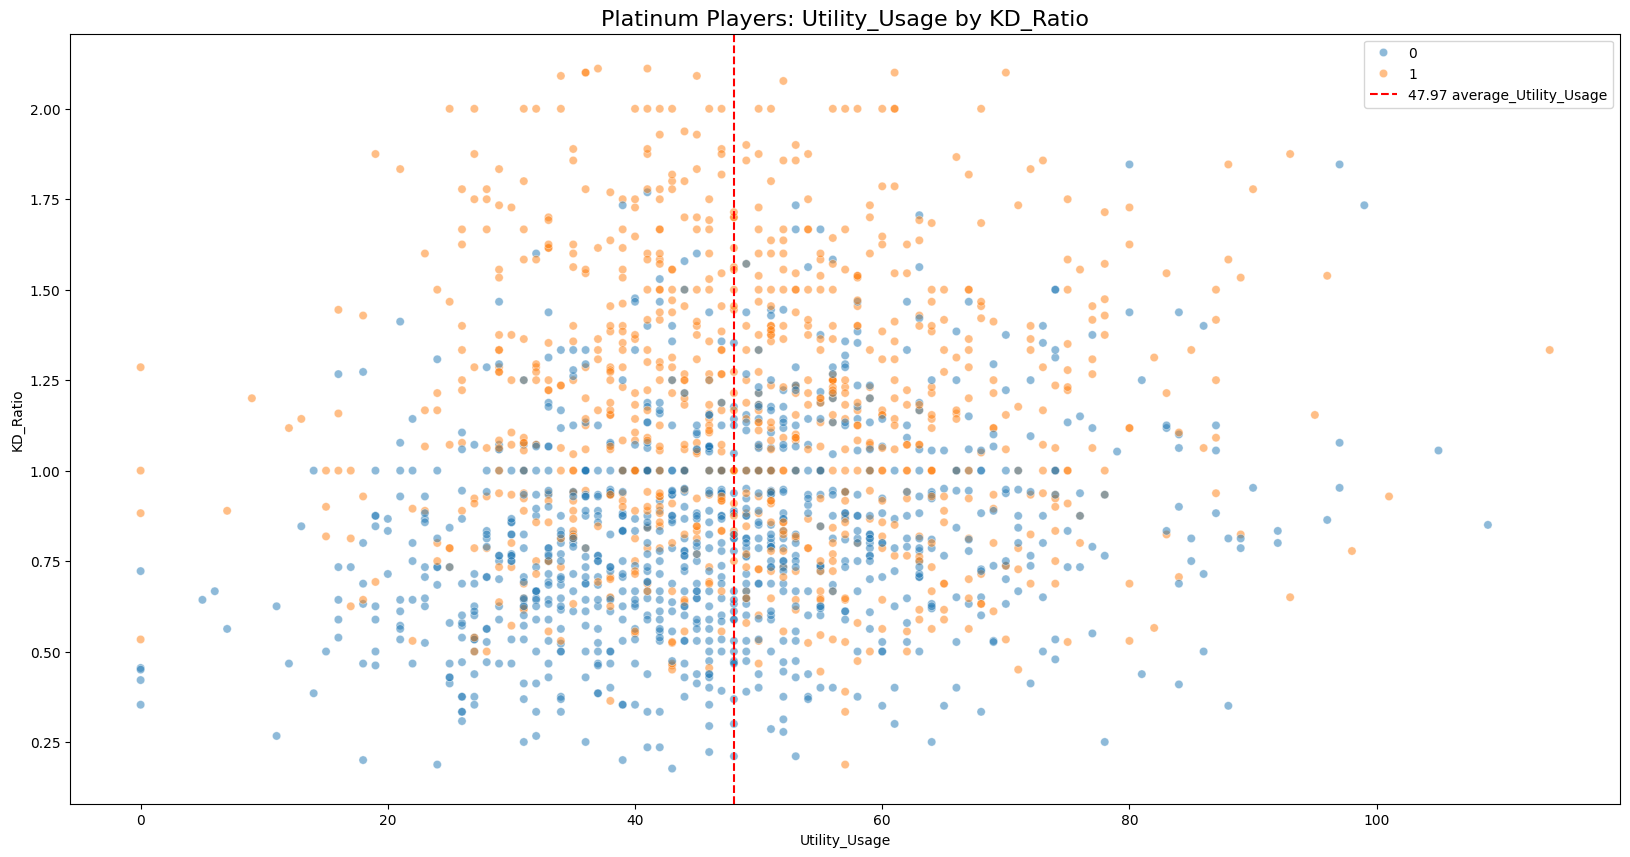

In [155]:
## create scatter plot of avg monthly hours vs satisfaction levels comparing stayed vs'Match_Result_Binary
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_platinumplayers, x='Utility_Usage', y='KD_Ratio', hue='Match_Result_Binary', alpha=0.5)
plt.axvline(x=47.97, color='red', label='47.97 average_Utility_Usage', ls='--')
plt.legend()
plt.title('Platinum Players: Utility_Usage by KD_Ratio', fontsize='16');

Platinum players seem to have a more centralized normal distabution. it is unclear whether util leads to victories

In [156]:
df_diamondorhigherplayers = df1[df1['Rank'].isin(['Diamond 3', 'Diamond 2', 'Diamond 1', 'Ascendant 1', 'Ascendant 2', 'Ascendant 3', 'Immortal 1'])]

In [157]:
average_diamondorhigher_Utility_Usage = df_diamondorhigherplayers['Utility_Usage'].mean()
print(average_diamondorhigher_Utility_Usage)

49.59542656112577


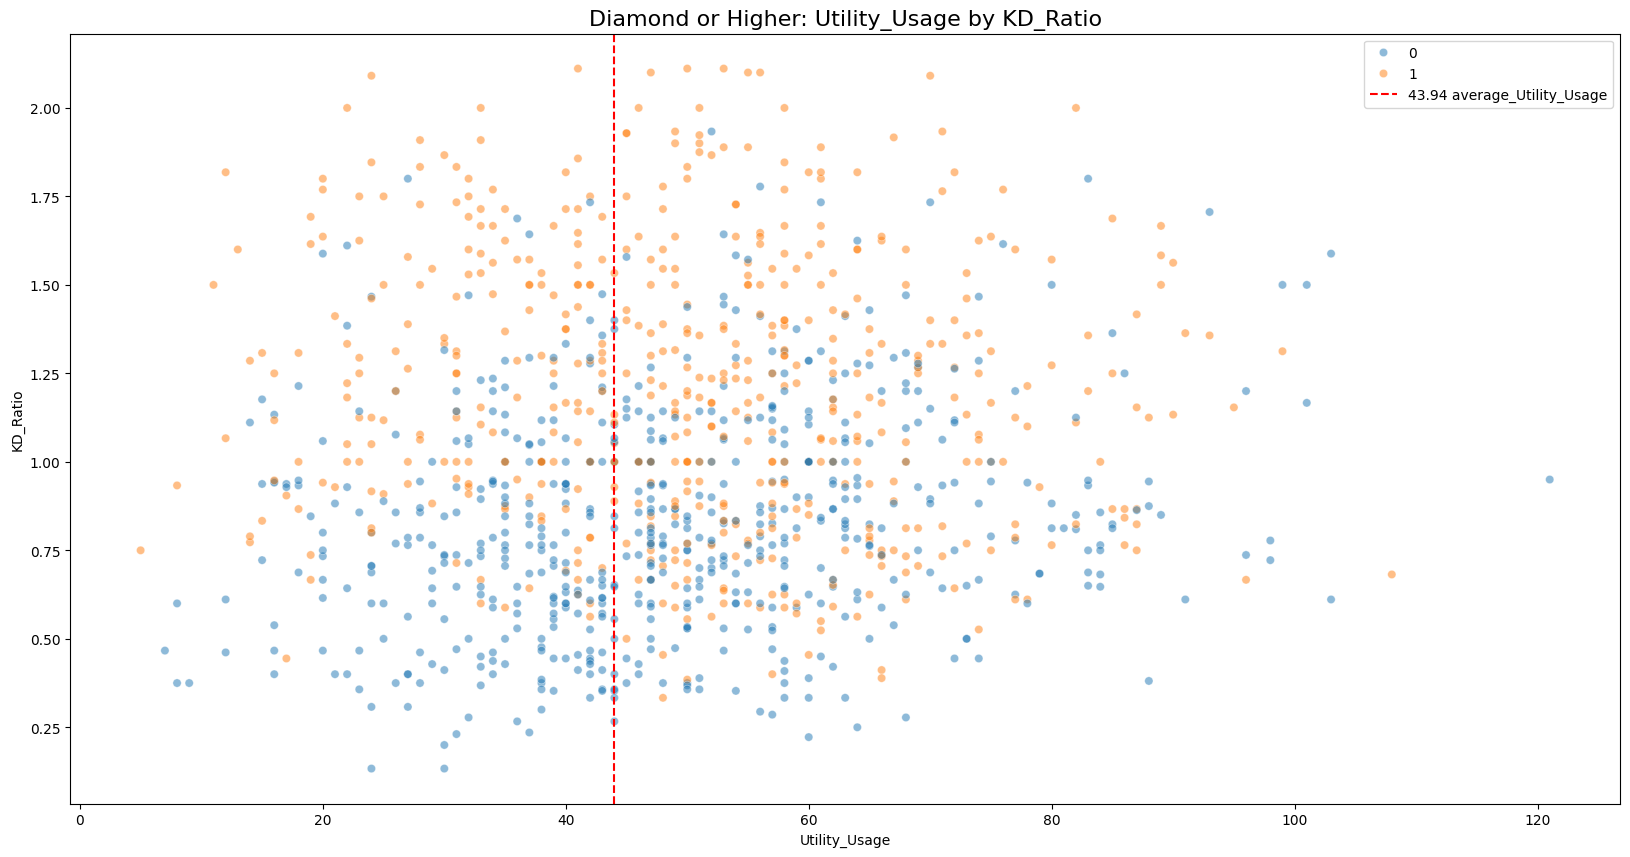

In [158]:
## create scatter plot of avg monthly hours vs satisfaction levels comparing stayed vs'Match_Result_Binary
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_diamondorhigherplayers, x='Utility_Usage', y='KD_Ratio', hue='Match_Result_Binary', alpha=0.5)
plt.axvline(x=43.94, color='red', label='43.94 average_Utility_Usage', ls='--')
plt.legend()
plt.title('Diamond or Higher: Utility_Usage by KD_Ratio', fontsize='16');

in Diamon or higher no games have 0 util usage. the higher the util usage with a lower KD_raito still seems to lead to victories

In [160]:
df_spicyn00dz = df1[df1['alias'].isin(['sp1cyn00dz'])]

In [165]:
average_spicyn00dz_Utility_Usage = df_spicyn00dz['Utility_Usage'].mean()
print(average_spicyn00dz_Utility_Usage)

29.119606358819077


### Player Datasets

Analysis of players data sets to see if there is a similar relationship to each rank player plays in. 

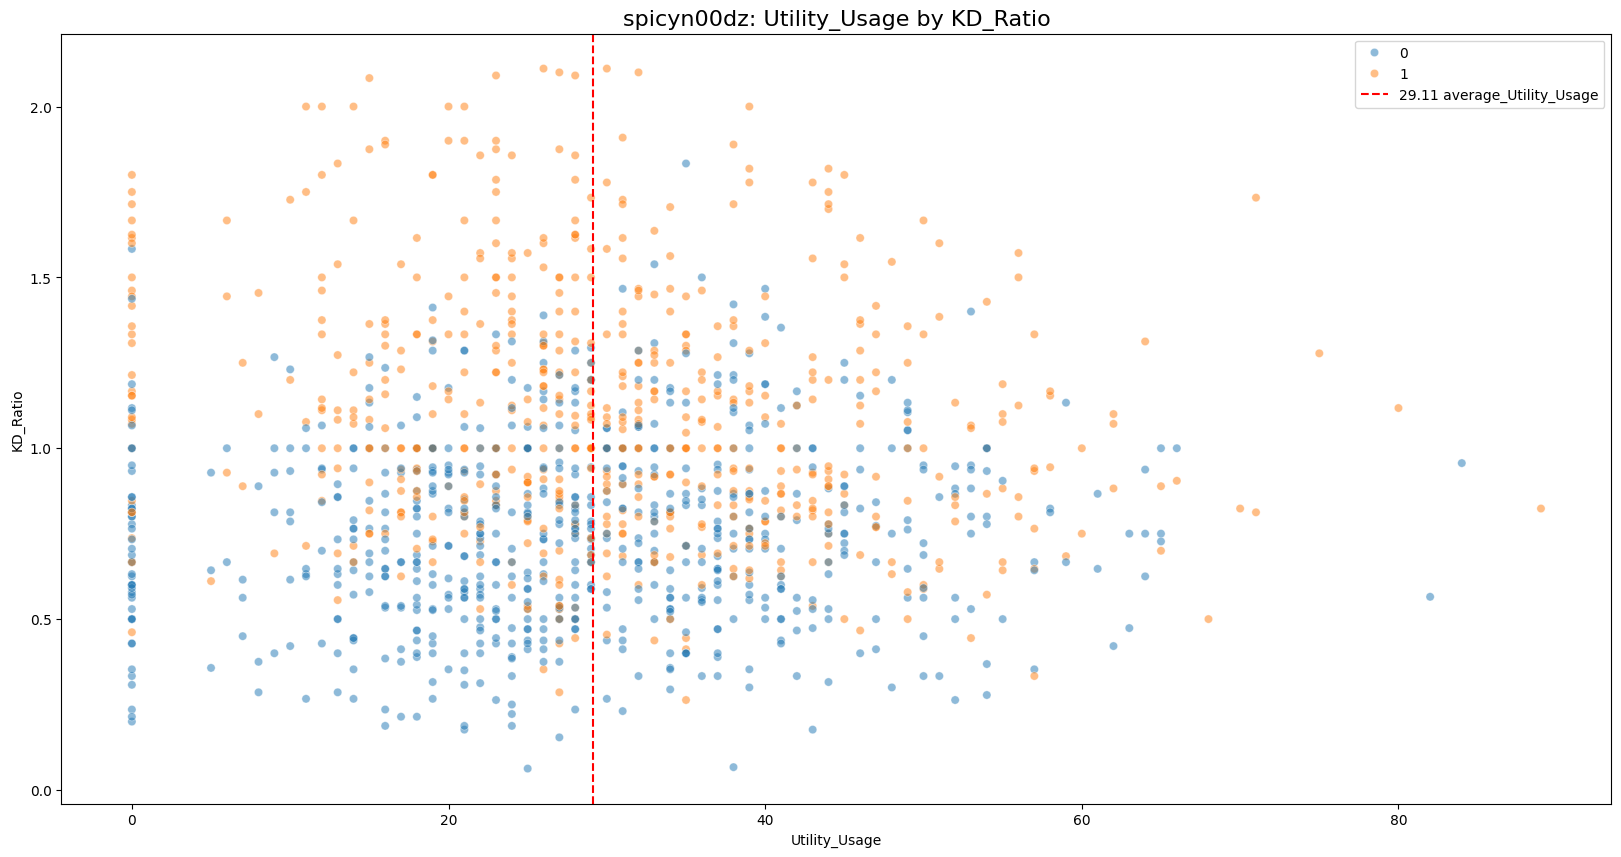

In [168]:
## create scatter plot of avg monthly hours vs satisfaction levels comparing stayed vs'Match_Result_Binary
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_spicyn00dz, x='Utility_Usage', y='KD_Ratio', hue='Match_Result_Binary', alpha=0.5)
plt.axvline(x=29.11, color='red', label='29.11 average_Utility_Usage', ls='--')
plt.legend()
plt.title('spicyn00dz: Utility_Usage by KD_Ratio', fontsize='16');

insight games with 0 util usage. the patter looks left skewed toward closer to gold players

In [163]:
df_silver = df1[df1['alias'].isin(['silver'])]

In [167]:
average_silver_Utility_Usage = df_silver['Utility_Usage'].mean()
print(average_silver_Utility_Usage)

51.302677532013966


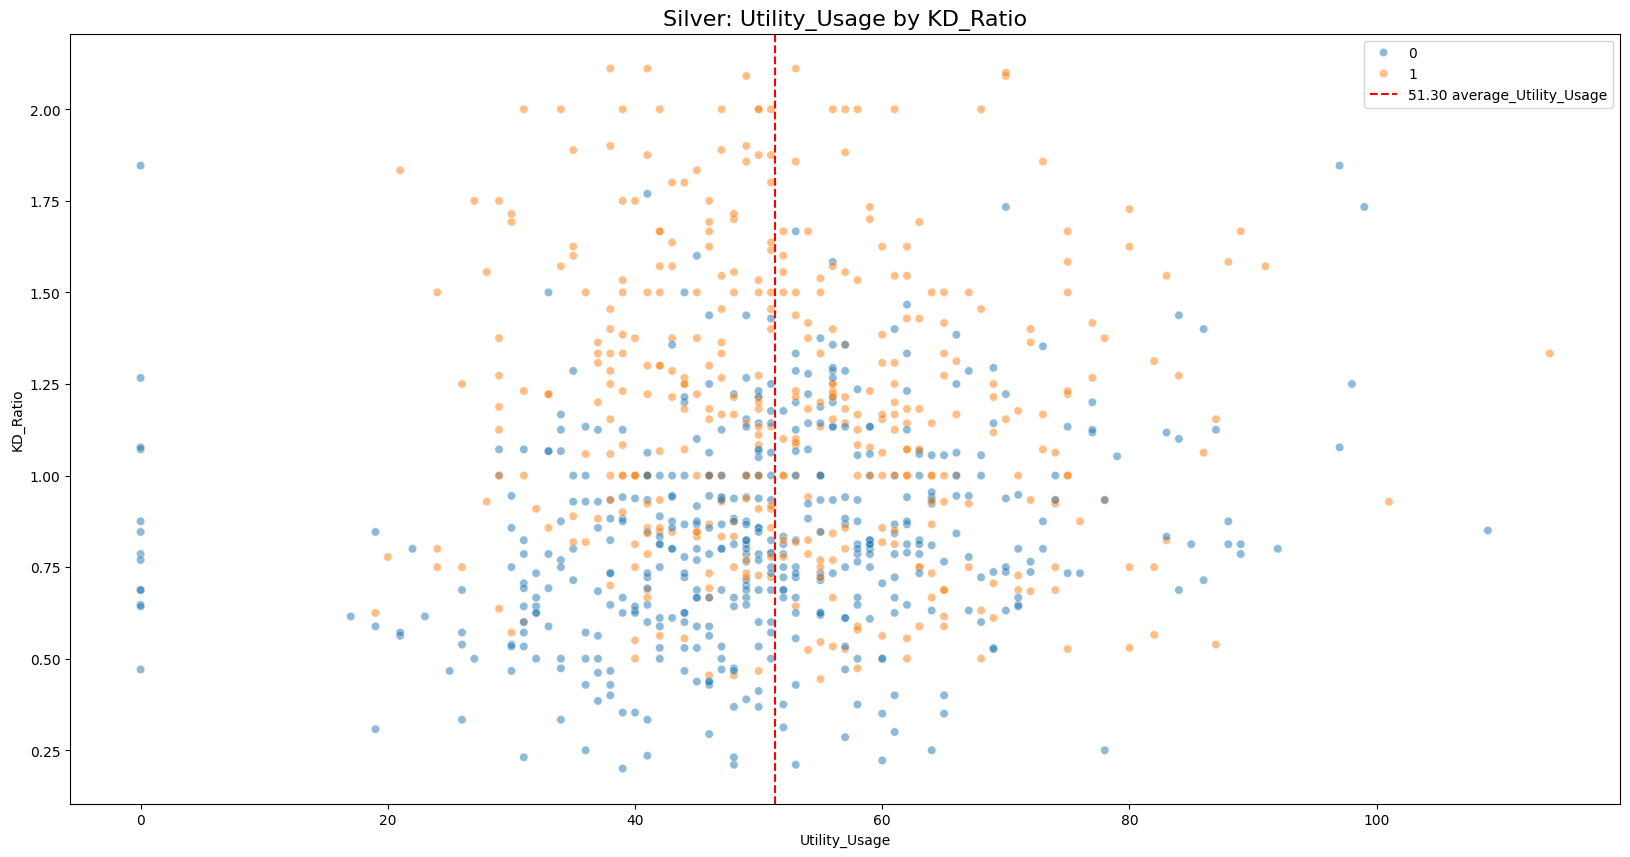

In [170]:
## create scatter plot of avg monthly hours vs satisfaction levels comparing stayed vs'Match_Result_Binary
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_silver, x='Utility_Usage', y='KD_Ratio', hue='Match_Result_Binary', alpha=0.5)
plt.axvline(x=51.30, color='red', label='51.30 average_Utility_Usage', ls='--')
plt.legend()
plt.title('Silver: Utility_Usage by KD_Ratio', fontsize='16');

the patter looks closer to platium players, has very few games with no util usage.

In [172]:
df_justsimple = df1[df1['alias'].isin(['justsimple'])]
average_justsimple_Utility_Usage = df_justsimple['Utility_Usage'].mean()
print(average_justsimple_Utility_Usage)

44.30193548387097


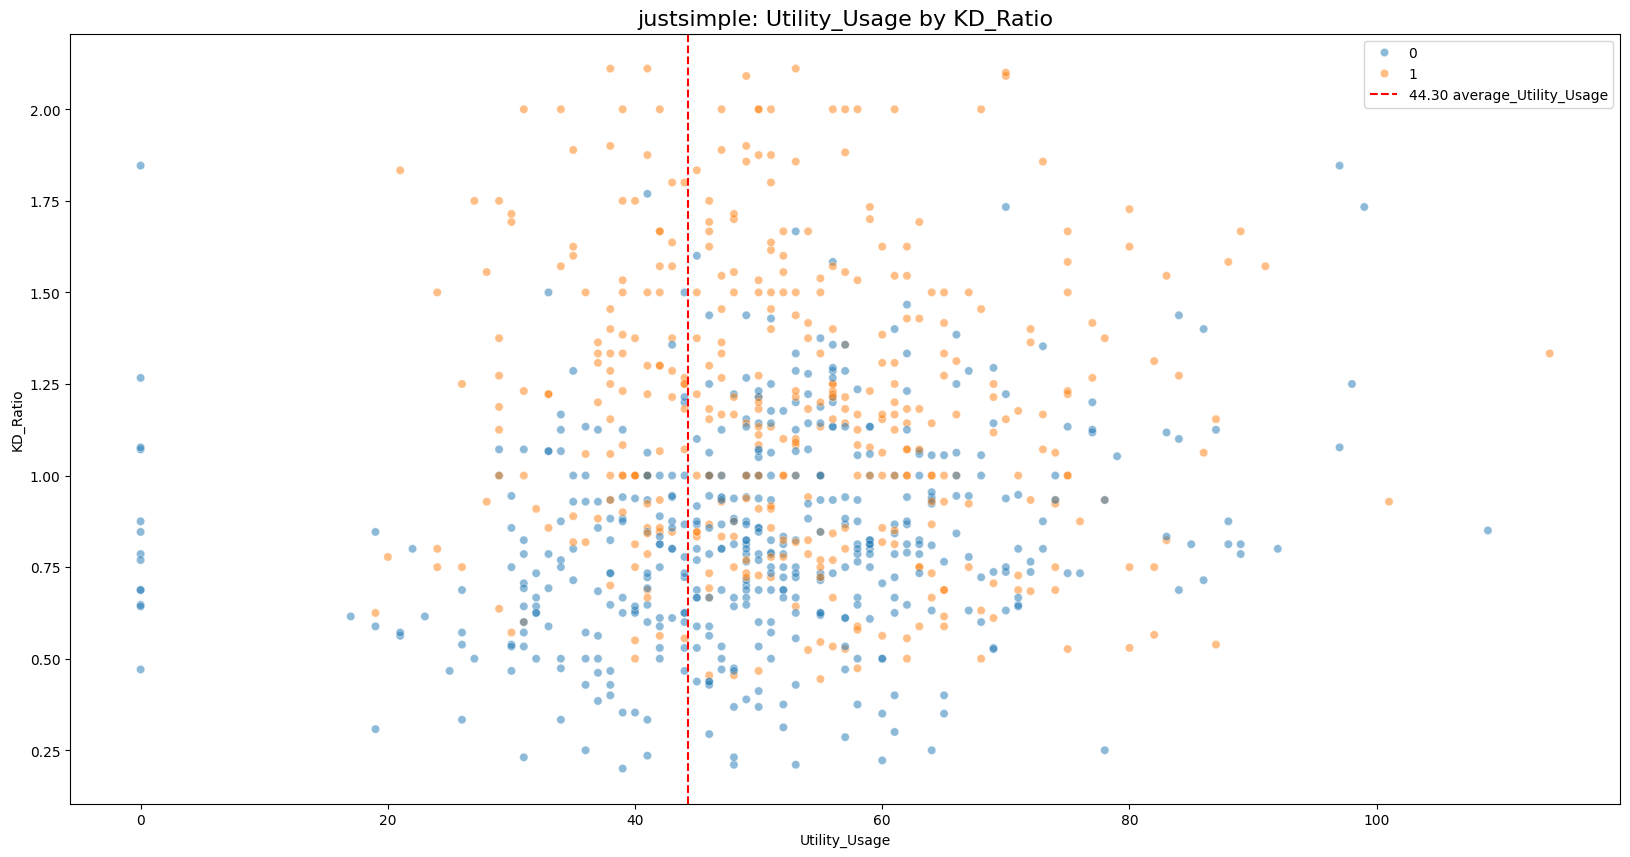

In [173]:
## create scatter plot of avg monthly hours vs satisfaction levels comparing stayed vs'Match_Result_Binary
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_silver, x='Utility_Usage', y='KD_Ratio', hue='Match_Result_Binary', alpha=0.5)
plt.axvline(x=44.30, color='red', label='44.30 average_Utility_Usage', ls='--')
plt.legend()
plt.title('justsimple: Utility_Usage by KD_Ratio', fontsize='16');

looks similar to silver patter

In [30]:
df2 = df1.copy()
df2['KD_Ratio'] = df2['KD_Ratio'].round(2)

# Add over all graph to show over all histogram to present to stake holder. Util by agent

### Kills vs Traded

A common issue where players will have a good KD_raito however not contribue to an overall victory is a concern. Exporting the relationship of kills and being traded after getting kills. 

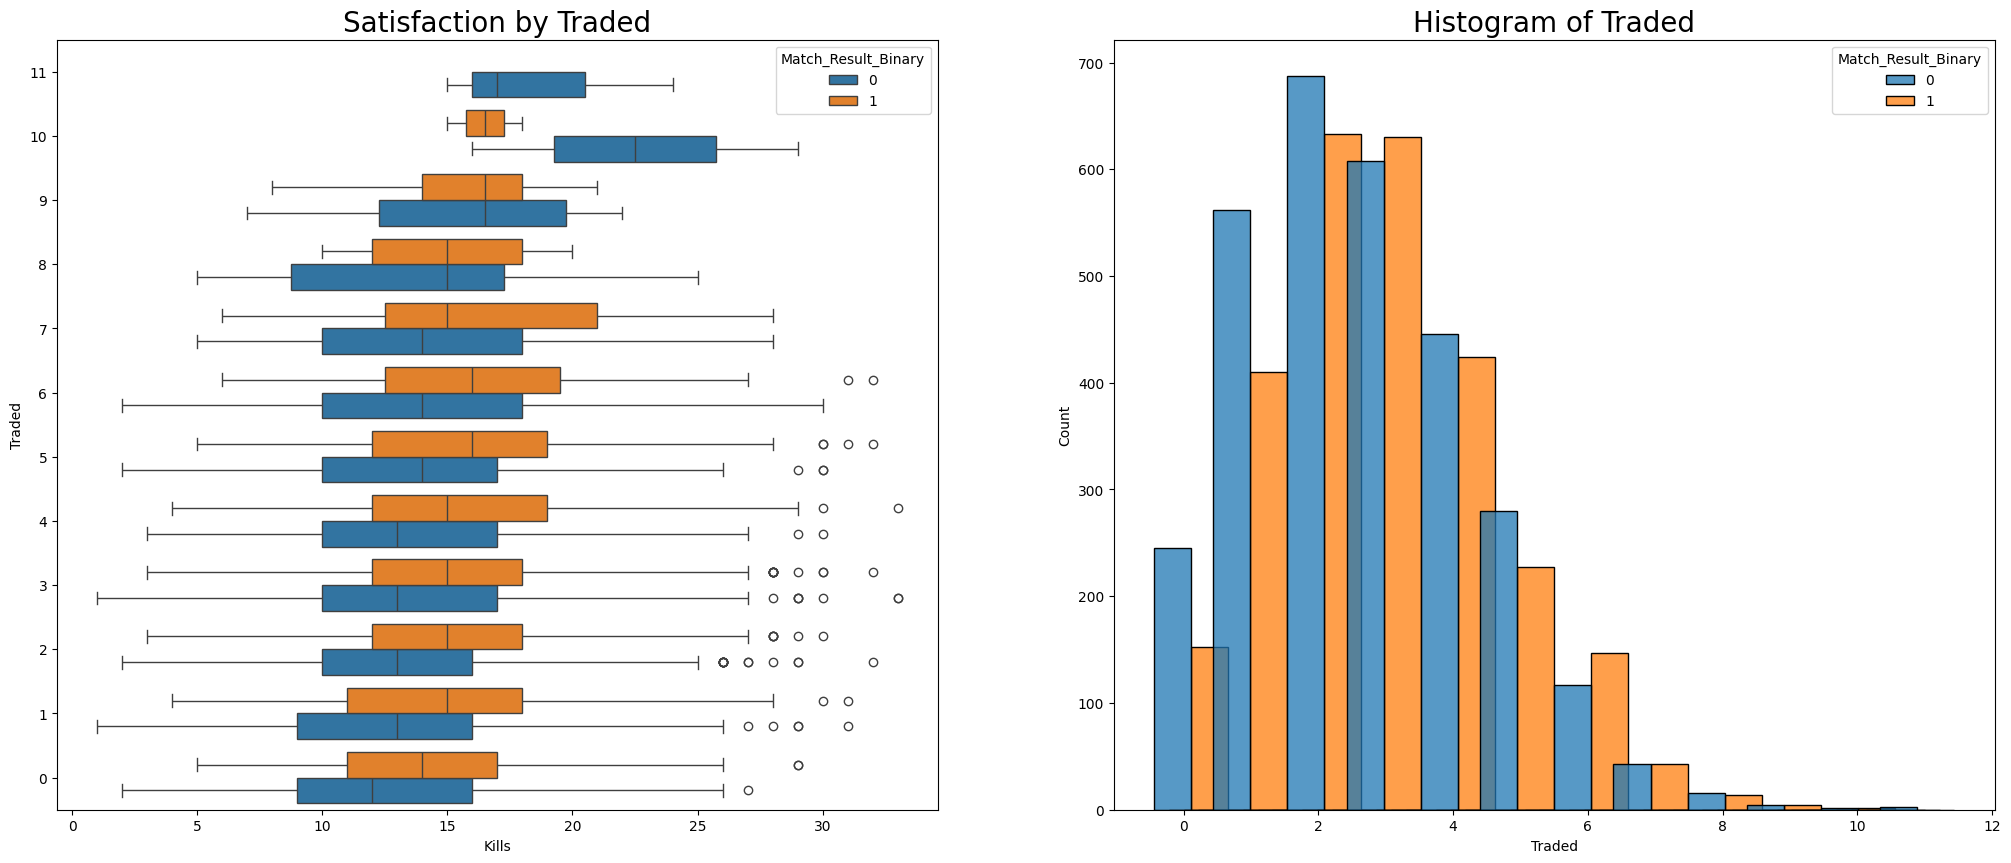

In [195]:
## plot Kills and Traded

## set figure and axes
fig, ax = plt.subplots(1, 2, figsize=(25,10))

##create boxplot of Kills by Traded, Match_Result_Binary
sns.boxplot(data=df2, x='Kills', y='Traded', hue='Match_Result_Binary', orient='h', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Kills by Traded', fontsize='20')

sns.histplot(data=df2, x='Traded', hue='Match_Result_Binary', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Histogram of Traded', fontsize='20')

plt.show();

keep pairs more space in historgram. explain tipping point

Histogram shows defeat condision

In [201]:
df2.groupby(['Match_Result_Binary'])['Traded'].agg([np.mean,np.median])

C:\Users\justs\AppData\Local\Temp\ipykernel_9220\3735584183.py:1: FutureWarning: The provided callable <function mean at 0x00000249D786EF20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df2.groupby(['Match_Result_Binary'])['Traded'].agg([np.mean,np.median])
C:\Users\justs\AppData\Local\Temp\ipykernel_9220\3735584183.py:1: FutureWarning: The provided callable <function median at 0x00000249D79CD9E0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df2.groupby(['Match_Result_Binary'])['Traded'].agg([np.mean,np.median])


mean  median
Match_Result_Binary                  
0                    2.709592     3.0
1                    2.884587     3.0

## Kills vs Clutches

Exploring the Idea of invidival performace leading the game victory. Clutching a round means you were last alive and winning the round in 1 v X scenarios.

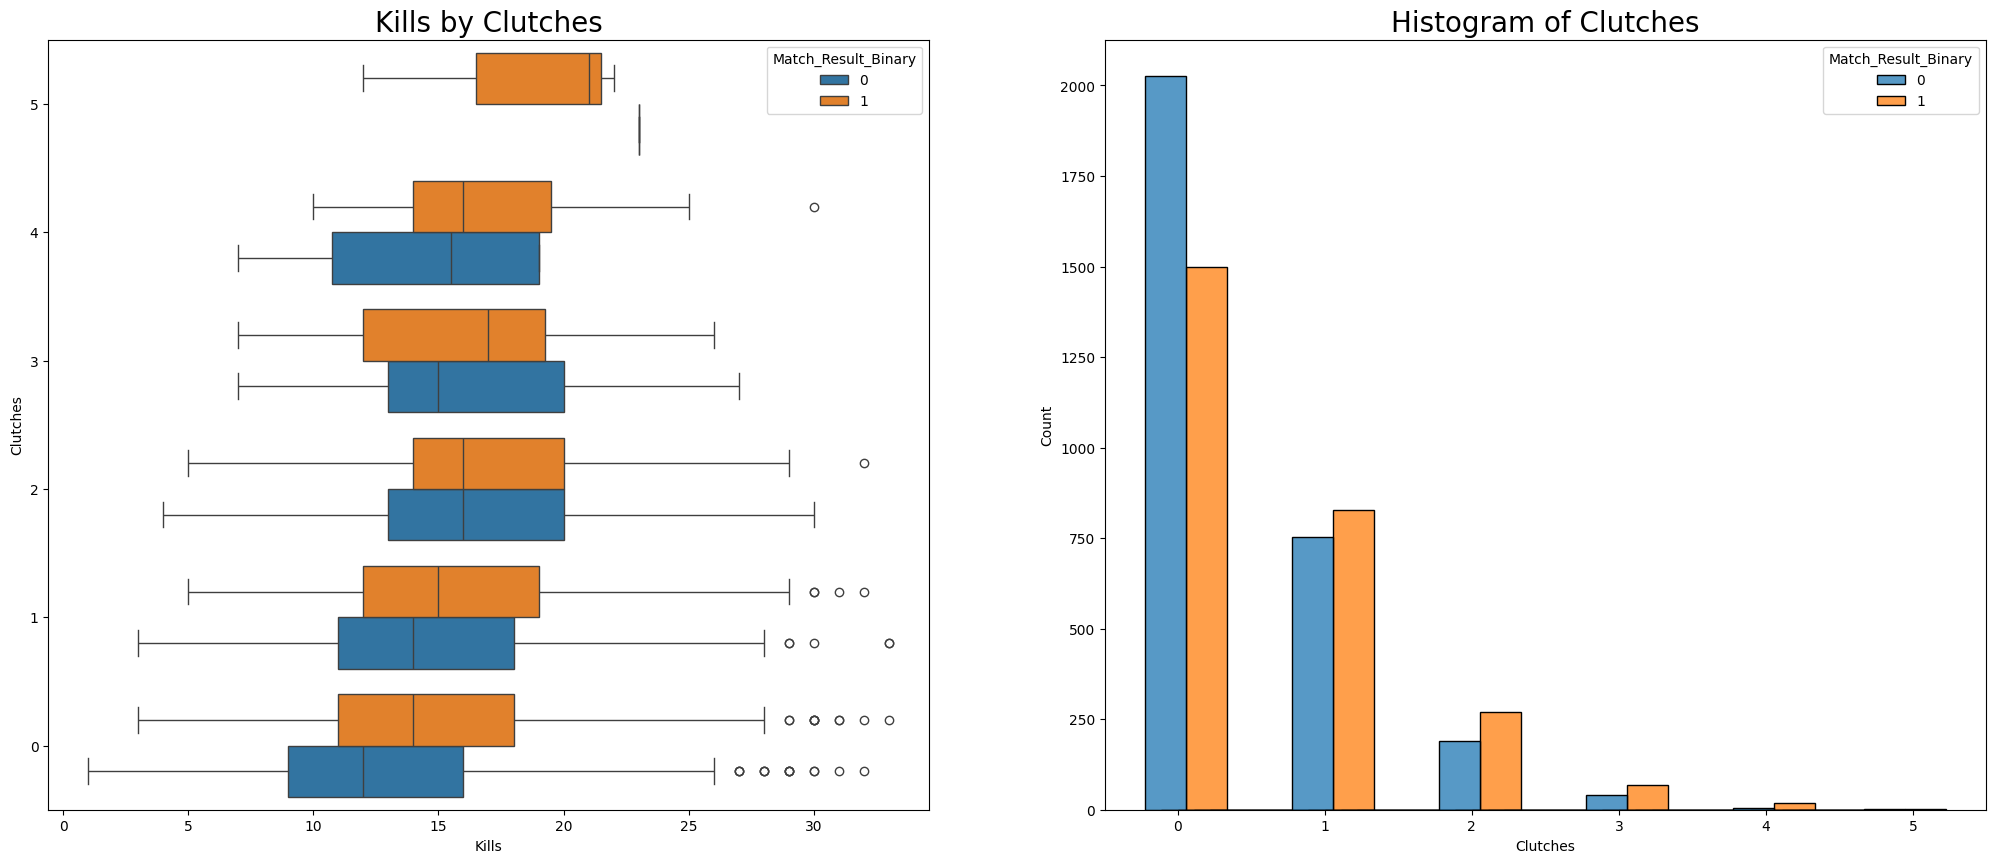

In [213]:
## plot Kills and Clutches

## set figure and axes
fig, ax = plt.subplots(1, 2, figsize=(25,10))

##create boxplot of Kills by Clutches, comparing empolyee Match_Result_Binary
sns.boxplot(data=df2, x='Kills', y='Clutches', hue='Match_Result_Binary', orient='h', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Kills by Clutches', fontsize='20')

sns.histplot(data=df2, x='Clutches', hue='Match_Result_Binary', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Histogram of Clutches', fontsize='20')

plt.show();

at least one clutch tipping point

stakeholder put win % for easier vis

In [200]:
df2.groupby(['Match_Result_Binary'])['Clutches'].agg([np.mean,np.median])

C:\Users\justs\AppData\Local\Temp\ipykernel_9220\264422422.py:1: FutureWarning: The provided callable <function mean at 0x00000249D786EF20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df2.groupby(['Match_Result_Binary'])['Clutches'].agg([np.mean,np.median])
C:\Users\justs\AppData\Local\Temp\ipykernel_9220\264422422.py:1: FutureWarning: The provided callable <function median at 0x00000249D79CD9E0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df2.groupby(['Match_Result_Binary'])['Clutches'].agg([np.mean,np.median])


mean  median
Match_Result_Binary                  
0                    0.422502     0.0
1                    0.618392     0.0

### Rounds won vs Last Deaths

Last deaths is the otherside of clutching. It is that the player was last alive however losing the clutch scenaro. This could be a sign of baiting the team and not comtrubiting to the win condition. 

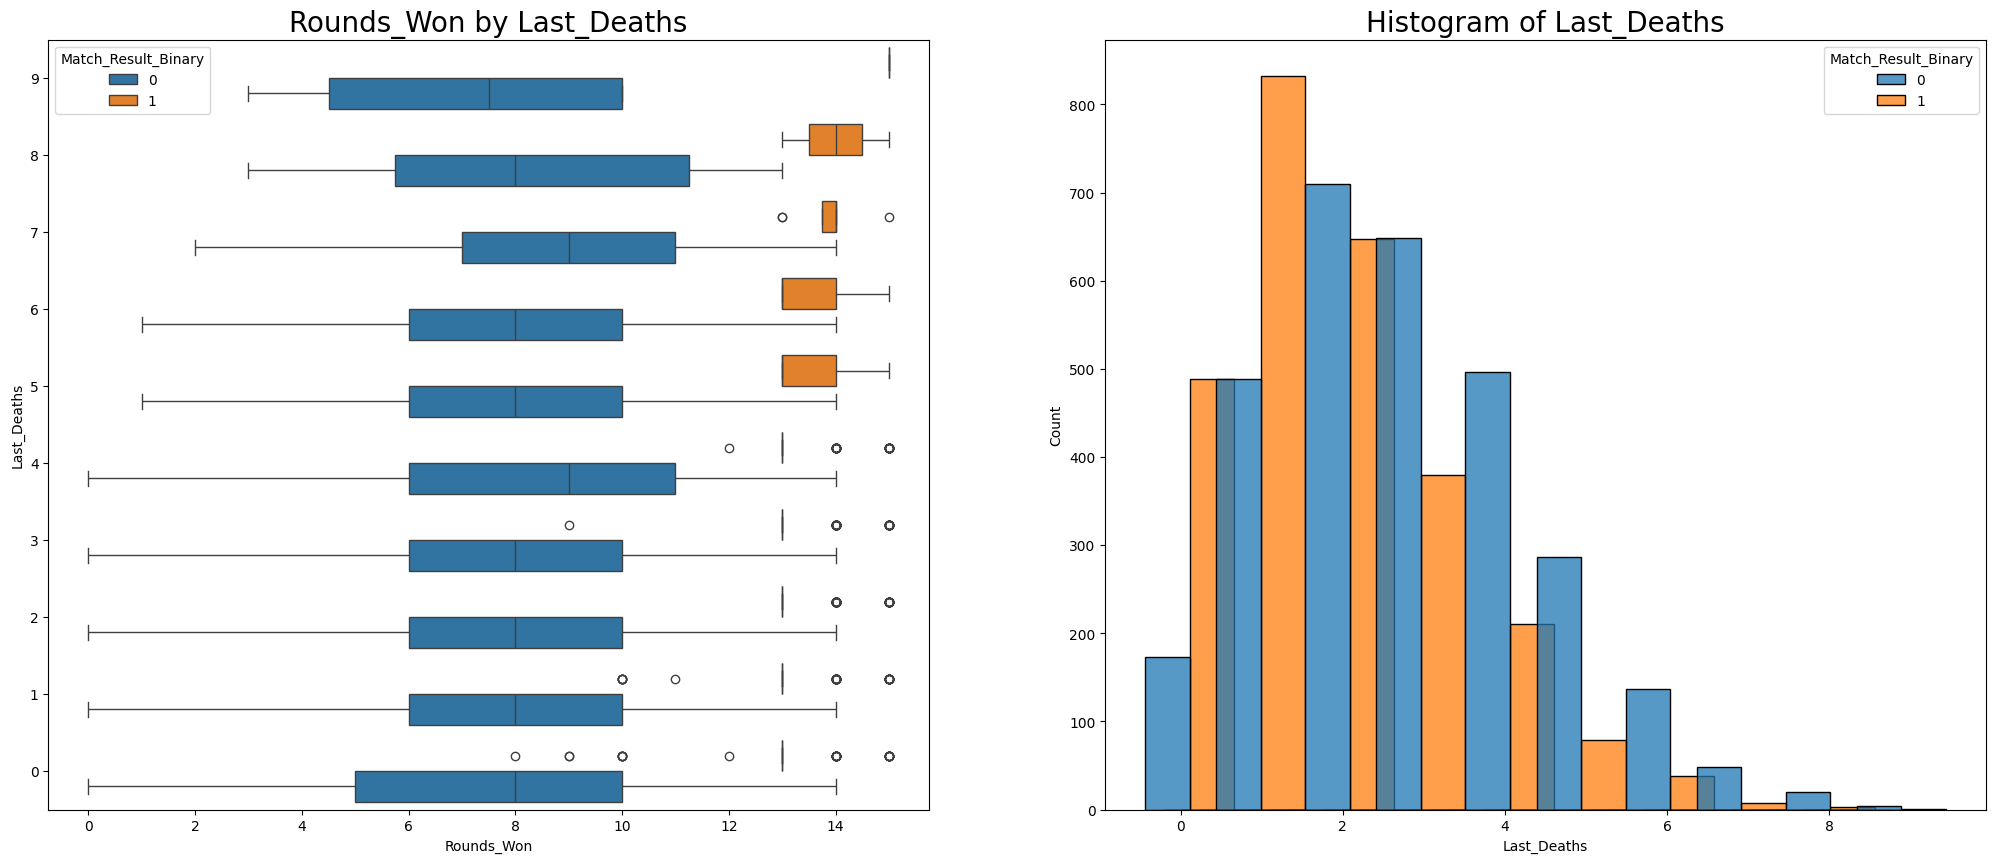

In [219]:
## plot Rounds_Won and Last_Deaths

## set figure and axes
fig, ax = plt.subplots(1, 2, figsize=(25,10))

##create boxplot of Rounds_Won by Last_Deaths, comparing empolyee Match_Result_Binary
sns.boxplot(data=df2, x='Rounds_Won', y='Last_Deaths', hue='Match_Result_Binary', orient='h', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Rounds_Won by Last_Deaths', fontsize='20')

sns.histplot(data=df2, x='Last_Deaths', hue='Match_Result_Binary', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Histogram of Last_Deaths', fontsize='20')

plt.show();

There seems to be a tipping point when it comes to last_deaths. if it is less that 4 the win rate seems return to 50% chance of victory or defeat. 

# Try round win ratio 

In [214]:
df2.groupby(['Match_Result_Binary'])['Last_Deaths'].agg([np.mean,np.median])

C:\Users\justs\AppData\Local\Temp\ipykernel_9220\4207814691.py:1: FutureWarning: The provided callable <function mean at 0x00000249D786EF20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df2.groupby(['Match_Result_Binary'])['Last_Deaths'].agg([np.mean,np.median])
C:\Users\justs\AppData\Local\Temp\ipykernel_9220\4207814691.py:1: FutureWarning: The provided callable <function median at 0x00000249D79CD9E0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df2.groupby(['Match_Result_Binary'])['Last_Deaths'].agg([np.mean,np.median])


mean  median
Match_Result_Binary                  
0                    2.863591     3.0
1                    1.793745     2.0

In [204]:
def set_iqr_limits(column):
    Q1 = df2[column].quantile(0.25)
    Q3 = df2[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return lower_limit, upper_limit


# Calculate outlier limits for 'Kills'
lower, upper = set_iqr_limits('Kills')
print(f"Kills: Lower Outlier Limit: {lower}, Upper Outlier Limit: {upper}")

# Create a new DataFrame without outliers
df_without_outliers_kills = df2[(df2['Kills'] <= upper) & (df2['Kills'] >= lower)]

# Display the new DataFrame without outliers
print("\nDataFrame without Kills outliers:")
print(df_without_outliers_kills)

Kills: Lower Outlier Limit: 0.5, Upper Outlier Limit: 28.5

DataFrame without Kills outliers:
                     Date Match_Result Map_Name        Rank       alias  \
0     2020-07-05 16:55:33      victory    Haven    Silver 3  sp1cyn00dz   
1     2020-07-11 18:09:27         tied    Split    Silver 3  sp1cyn00dz   
2     2020-07-13 17:37:42      victory    Split      Gold 2       shift   
3     2020-07-17 13:53:38       defeat    Split    Silver 3  sp1cyn00dz   
4     2020-07-21 16:06:02       defeat     Bind    Silver 3  sp1cyn00dz   
...                   ...          ...      ...         ...         ...   
6227  2024-09-20 19:55:44      victory    Haven  Platinum 2      silver   
6228  2024-09-20 20:36:12       defeat    Lotus  Platinum 3      silver   
6229  2024-09-20 21:09:42       defeat   Sunset  Platinum 3      silver   
6230  2024-09-20 21:55:52       defeat     Bind  Platinum 2      silver   
6232  2024-09-22 19:19:23      victory    Abyss  Platinum 2      silver   

     

### Traded vs Kills ordered in low med, or high

Segmenting traded values to see a relationship of number of kills. This is looking into the idea of a team player who is playing with the team. The idea is if the player is close to teammates there is a higher chance of the player being traded. 

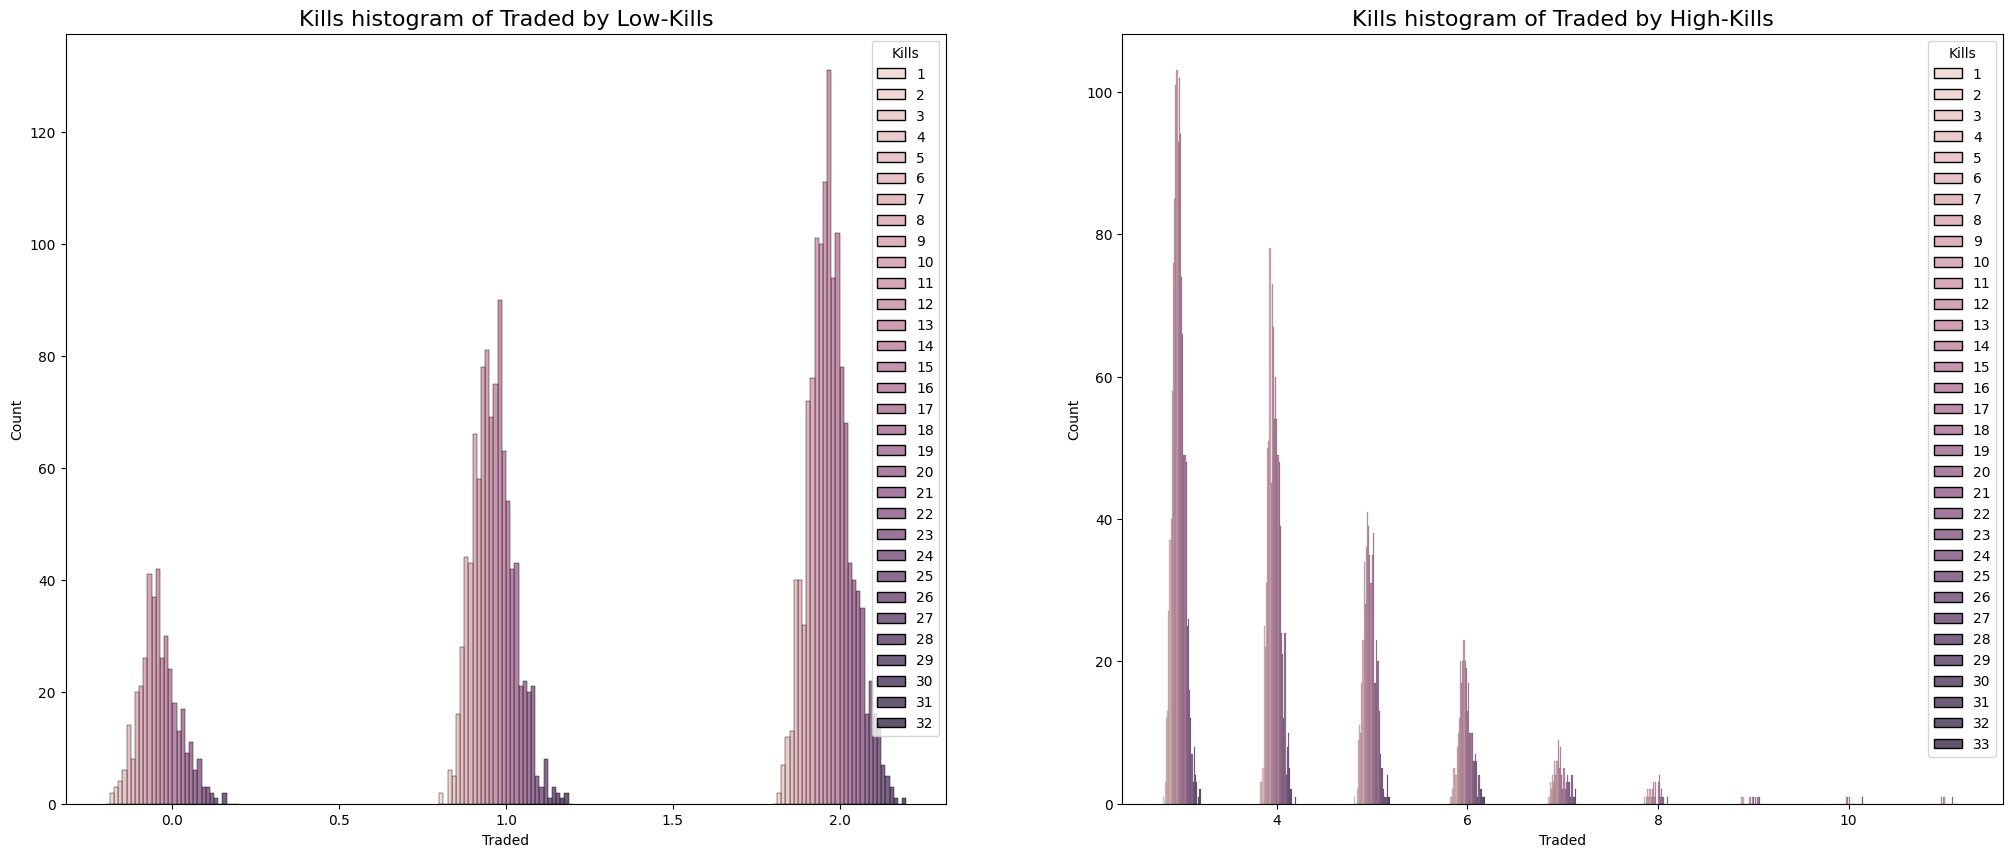

In [209]:
## create hisplot for Traded and Kills

## figures and axes
fig, ax = plt.subplots(1, 2, figsize=(25,10))

## define low Traded
traded_short = df2[df2['Traded'] < 3]

## define high Traded
traded_long = df2[df2['Traded'] > 2]

## plot short Traded histogram
sns.histplot(data=traded_short, x='Traded',
             hue='Kills',
             discrete=1,
             hue_order=['low', 'medium', 'high'],
             multiple='dodge',
             shrink=.4,
             ax=ax[0])
ax[0].set_title('Kills histogram of Traded by Low-Kills', fontsize='16')

## plot long Traded histogram
sns.histplot(data=traded_long, x='Traded',
             hue='Kills',
             discrete=1,
             hue_order=['low', 'medium', 'high'],
             multiple='dodge',
             shrink=.4,
             ax=ax[1])
ax[1].set_title('Kills histogram of Traded by High-Kills', fontsize='16');


Make IQR for better clarity

## Agent pick vs match result

Looking for any outliers of agent picks in the data set. This may be due to agent out of meta or players ability to maximize the perfornace of said agent. 

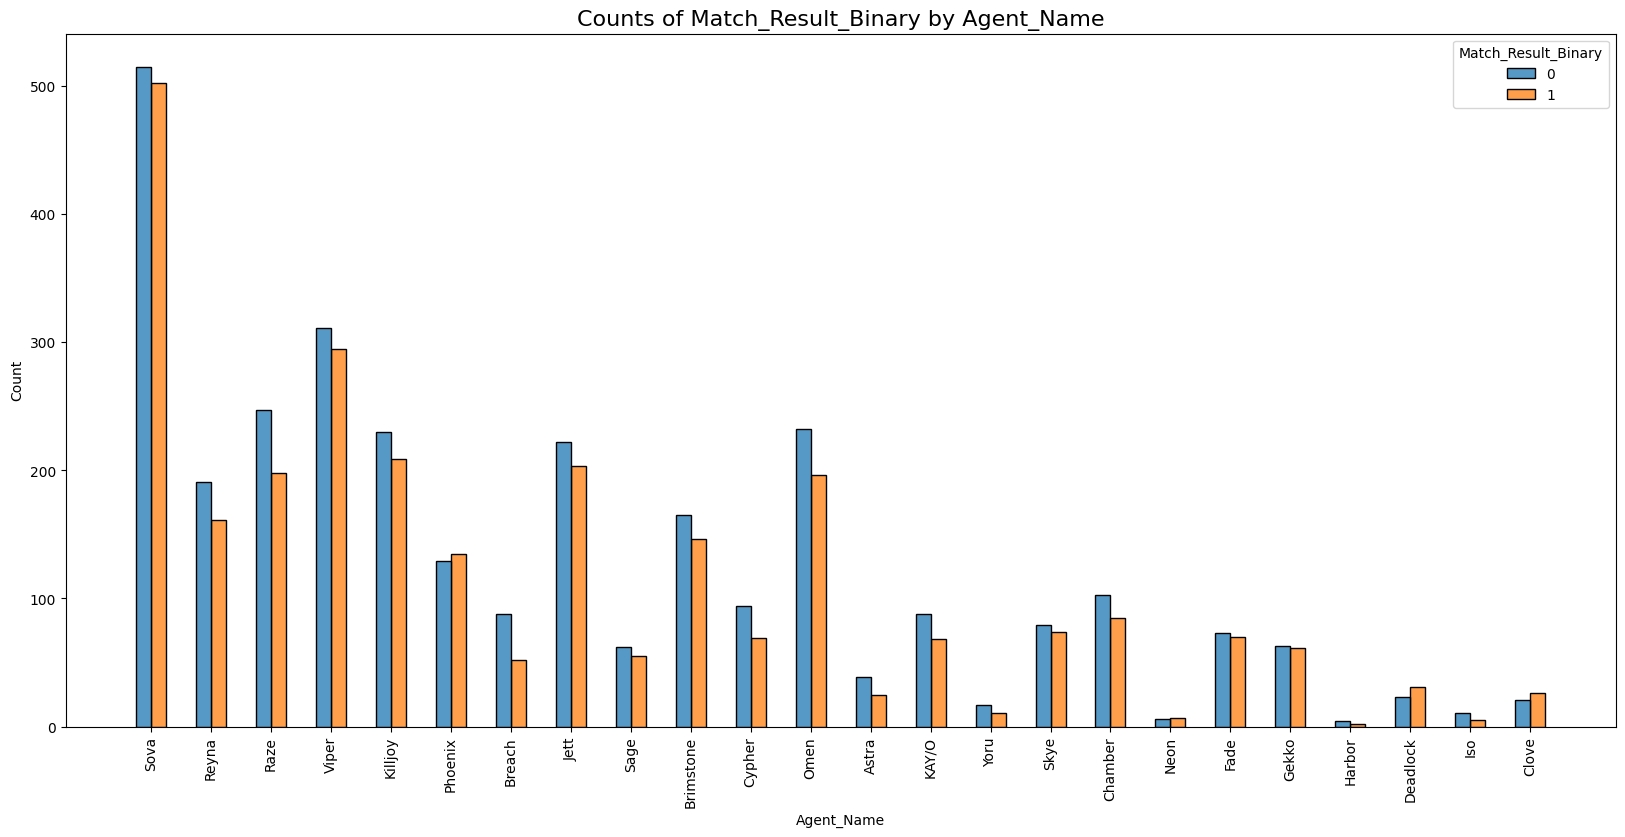

In [32]:
plt.figure(figsize=(20, 9))
sns.histplot(
    data=df1, 
    x='Agent_Name', 
    hue='Match_Result_Binary',
    discrete=True,  # Use this for categorical x-axis
    hue_order=[0, 1],  # Ensure these match the actual values in your data
    multiple='dodge', 
    shrink=0.5
)

plt.xticks(rotation='vertical')
plt.title('Counts of Match_Result_Binary by Agent_Name', fontsize='16')
plt.show()

# more graph ideas

KD_ratio per agent
clutch per agent

ask alex, tim, dk and justin of graph ideas


In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5699 entries, 0 to 6232
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               5699 non-null   object 
 1   Match_Result                       5699 non-null   object 
 2   Map_Name                           5699 non-null   object 
 3   Rank                               5699 non-null   object 
 4   alias                              5699 non-null   object 
 5   Agent_Name                         5699 non-null   object 
 6   Match_Result_Binary                5699 non-null   int64  
 7   Kills                              5699 non-null   int64  
 8   Deaths                             5699 non-null   int64  
 9   Headshots_Percentage               5699 non-null   float64
 10  Headshots                          5699 non-null   int64  
 11  Assists                            5699 non-null   int64  
 1

In [33]:
df_numeric = df2.select_dtypes(include=['number'])
df_numeric.head()

Match_Result_Binary  Kills  Deaths  Headshots_Percentage  Headshots  \
0                    1     21      13             13.253012         10   
1                    0     12      20             14.545455          7   
2                    1      8      10             14.285714          4   
3                    0      9       7              7.692308          2   
4                    0      7       9             24.000000          5   

   Assists  Damage  Damage_Delta_Per_Round  Damage_Per_Round  Damage_Received  \
0        3    4102               85.095238        195.333333             2315   
1        6    2685              -37.172414         92.586207             3763   
2        4    1598              -31.764706         94.000000             2138   
3        4    1520                3.269231         58.461538             1435   
4        2    1536              -39.769231        118.153846             2053   

   ...  Clutches  Round_Ratio  Rounds_Lost  Rounds_Played  Rounds_Won  \
0  ...         1     1.625000            8             21          13   
1  ...         1     1.000000           14             29          14   
2  ...         3     3.250000            4             17          13   
3  ...         0     0.857143           14             26          12   
4  ...         0     0.384615           13             13           5   

   Team_Aces  Thrifty  Traded  TRN_Performance_Score  Utility_Usage  
0         10        5       0                    860           31.0  
1          7        5       1                    278            0.0  
2          4        3       0                    425           33.0  
3          2        8       1                    293           21.0  
4          5        4       0                    267            0.0  

[5 rows x 35 columns]

### Selecting and looking for correlation of important varibles

narrowing the varibles for the model. Looking at any outstanding relationships between the new set of varibles

In [34]:
# Define the columns to keep
columns_to_keep = [
    'Headshots_Percentage', 
    'KD_Ratio', 
    'Traded', 
    'Utility_Usage', 
    'Match_Result_Binary', 
    'KAST', 
    'Last_Deaths',
    'First_Bloods',
    'First_Deaths',
    'Clutches'
]

# Create a new DataFrame with only the specified columns
df_numeric_filtered = df_numeric[columns_to_keep]

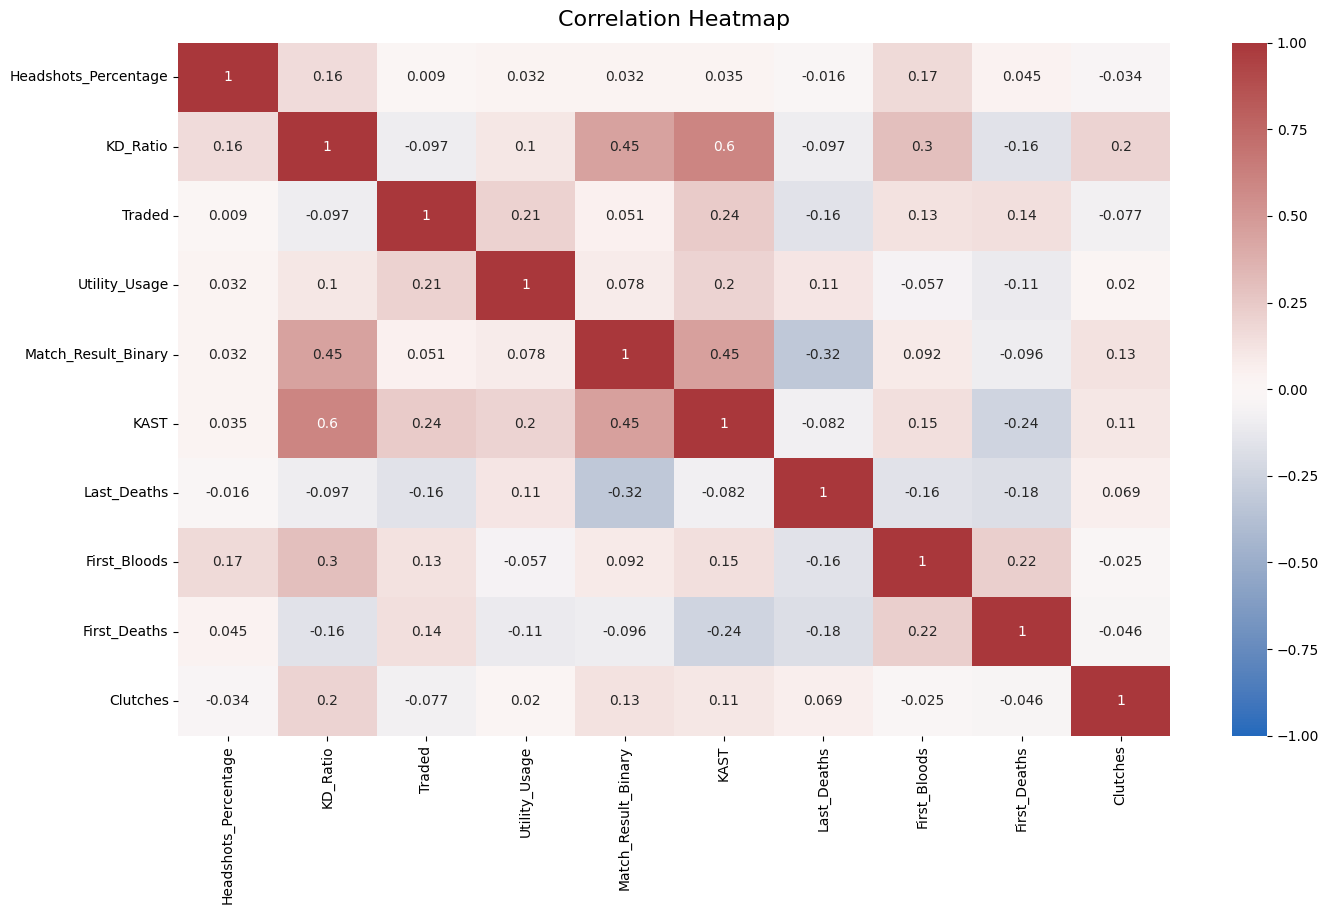

In [249]:
plt.figure(figsize=(16,9))
heatmap = sns.heatmap(df_numeric_filtered.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette('vlag', as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=12);


### Creating a new relationship of Roles

Each Agent in Valorant belongs to a role that dictates their playstyle on the team. For example, Duelists are designed to engage in fights and take space on the map, while Sentinels hold positions and play more defensively. Creating a column to show this relationship.

In [253]:
# Define the agent-role mapping
agent_role_mapping = {
    'Brimstone': 'Controller',
    'Viper': 'Controller',
    'Omen': 'Controller',
    'Cypher': 'Sentinel',
    'Killjoy': 'Sentinel',
    'Sage': 'Sentinel',
    'Phoenix': 'Duelist',
    'Jett': 'Duelist',
    'Reyna': 'Duelist',
    'Raze': 'Duelist',
    'Breach': 'Initiator',
    'KAY/O': 'Initiator',
    'Skye': 'Initiator',
    'Yoru': 'Duelist',
    'Harbor': 'Controller',
    'Vyse': 'Sentinel',
    'Astra': 'Controller',
    'Neon': 'Duelist',
    'Gekko': 'Initiator',
    'Chamber': 'Sentinel',
    'Deadlock': 'Sentinel',
    'Iso': 'Duelist',
    'Clove': 'Controller',
    'Fade': 'Initiator',
    'Sova': 'Initiator'
}

# Add the 'Role' column based on the agent-role mapping
df2['Role'] = df2['Agent_Name'].map(agent_role_mapping)

df2.head()

Date Match_Result Map_Name      Rank       alias Agent_Name  \
0  2020-07-05 16:55:33      victory    Haven  Silver 3  sp1cyn00dz       Sova   
1  2020-07-11 18:09:27         tied    Split  Silver 3  sp1cyn00dz       Sova   
2  2020-07-13 17:37:42      victory    Split    Gold 2       shift      Reyna   
3  2020-07-17 13:53:38       defeat    Split  Silver 3  sp1cyn00dz       Sova   
4  2020-07-21 16:06:02       defeat     Bind  Silver 3  sp1cyn00dz       Sova   

   Match_Result_Binary  Kills  Deaths  Headshots_Percentage  ...  Team_Aces  \
0                    1     21      13             13.253012  ...         10   
1                    0     12      20             14.545455  ...          7   
2                    1      8      10             14.285714  ...          4   
3                    0      9       7              7.692308  ...          2   
4                    0      7       9             24.000000  ...          5   

   Thrifty  Traded  TRN_Performance_Score  KD_Ratio_is_outlier  \
0        5       0                    860                False   
1        5       1                    278                False   
2        3       0                    425                False   
3        8       1                    293                False   
4        4       0                    267                False   

   Damage_Per_Round_is_outlier  Damage_Delta_Per_Round_is_outlier  \
0                        False                              False   
1                        False                              False   
2                        False                              False   
3                        False                              False   
4                        False                              False   

   Rounds_Played_is_outlier  Utility_Usage       Role  
0                     False           31.0  Initiator  
1                     False            0.0  Initiator  
2                     False           33.0    Duelist  
3                     False           21.0  Initiator  
4                     False            0.0  Initiator  

[5 rows x 46 columns]

In [24]:
df2['Date'].head()


0    2020-07-05 16:55:33
1    2020-07-11 18:09:27
2    2020-07-13 17:37:42
3    2020-07-17 13:53:38
4    2020-07-21 16:06:02
Name: Date, dtype: object

In [280]:
# First, ensure the 'Date' column is converted to datetime
df2['Date'] = pd.to_datetime(df2['Date'], errors='coerce')

# Now, split the column into separate 'Date' and 'Time' columns
df2['Only_Date'] = df2['Date'].dt.date  # Extract the date part

# Extract time in the format of HH:MM:SS
df2['Only_Time'] = df2['Date'].dt.strftime('%H:%M:%S')

# Print to check the new columns
print(df2[['Only_Date', 'Only_Time']].head())

      Only_Date Only_Time
192  2021-02-20  20:21:17
194  2021-02-22  16:57:42
197  2021-02-23  16:54:05
199  2021-02-25  17:54:06
205  2021-02-27  18:41:56


C:\Users\justs\AppData\Local\Temp\ipykernel_9220\3404714173.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['Date'] = pd.to_datetime(df2['Date'], errors='coerce')


In [35]:
# Assuming your DataFrame is named df2
df2 = df2.drop(columns=['Date'])




## paCe: Contruct Stage
 - Choose models
 - Construct model
 - Confirm model assumptions
 - evalute model

#### Logistic Regression model

- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size



In [286]:
df2.head()

Match_Result Map_Name      Rank       alias Agent_Name  \
192      victory   Icebox  Bronze 3      pphead       Jett   
194       defeat   Icebox  Silver 1  sp1cyn00dz    Phoenix   
197       defeat    Split  Silver 1  sp1cyn00dz       Sova   
199      victory    Haven  Silver 1  sp1cyn00dz       Sova   
205       defeat   Icebox  Silver 1  sp1cyn00dz    Phoenix   

     Match_Result_Binary  Kills  Deaths  Headshots_Percentage  Headshots  ...  \
192                    1     14      14             10.638298          5  ...   
194                    0     16      13             23.404255         11  ...   
197                    0     19      16             14.864865          9  ...   
199                    1     11      14             10.638298          3  ...   
205                    0     13      17             15.217391          7  ...   

     Traded  TRN_Performance_Score  KD_Ratio_is_outlier  \
192       2                    549                False   
194       0                    452                False   
197       0                    662                False   
199       1                    547                False   
205       1                    195                False   

     Damage_Per_Round_is_outlier  Damage_Delta_Per_Round_is_outlier  \
192                        False                              False   
194                        False                              False   
197                        False                              False   
199                        False                              False   
205                        False                              False   

     Rounds_Played_is_outlier  Utility_Usage       Role   Only_Date  Only_Time  
192                     False           42.0    Duelist  2021-02-20   20:21:17  
194                     False           10.0    Duelist  2021-02-22   16:57:42  
197                     False           40.0  Initiator  2021-02-23   16:54:05  
199                     False           40.0  Initiator  2021-02-25   17:54:06  
205                     False           14.0    Duelist  2021-02-27   18:41:56  

[5 rows x 47 columns]

In [36]:
df_numeric_filtered_enc = df_numeric_filtered.copy()

In [37]:
def set_iqr_limits(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    lower_limit = Q1 - 1.5 * IQR  # Lower bound
    upper_limit = Q3 + 1.5 * IQR  # Upper bound
    return lower_limit, upper_limit

# Select only numeric columns from the DataFrame
numeric_columns = df_numeric_filtered_enc.select_dtypes(include=['float64', 'int64']).columns

# Apply IQR filtering to all numeric columns
for column in numeric_columns:
    lower, upper = set_iqr_limits(df_numeric_filtered_enc, column)
    df_numeric_filtered_enc = df_numeric_filtered_enc[(df_numeric_filtered_enc[column] >= lower) & (df_numeric_filtered_enc[column] <= upper)]  # Filter out outliers


In [38]:
from sklearn.metrics import confusion_matrix

# Assuming 'Match_Result_Binary' is your target variable
X = df_numeric_filtered_enc.drop(columns=['Match_Result_Binary'])  # All other columns as features
y = df_numeric_filtered_enc['Match_Result_Binary']  # Target column

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

## logistic regression model to get predictions on test set
y_pred = log_clf.predict(X_test)



#### Confusion Matrix of the model

True negatives: Player Match results Defeat that the model accurately predicted Defeat.

False positives: Player Match results did not get Victory the model inaccurately predicted Victory.

False negatives: Player Match results Victory that the model inaccurately predicted Victory

True positives: Player Match results Victory that the model accurately predicted Victory

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

next, create a classification report that includes precision, recall, accurcay, f1 scores to evaluate the performance of the model. Also, check the balance of the class to contexualize accuracy in the scores.

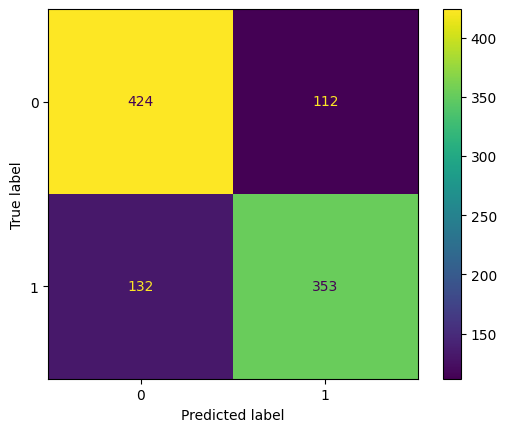

In [39]:
## compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

## create confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

## plot and display confusion matrix
log_disp.plot(values_format='')
plt.show()

In [40]:
target_names = ['Predicted Match end in Victory', 'Pedicted Match end in Defeat']
print(classification_report(y_test, y_pred, target_names=target_names))


                                precision    recall  f1-score   support

Predicted Match end in Victory       0.76      0.79      0.78       536
  Pedicted Match end in Defeat       0.76      0.73      0.74       485

                      accuracy                           0.76      1021
                     macro avg       0.76      0.76      0.76      1021
                  weighted avg       0.76      0.76      0.76      1021



In [300]:
# Align y with X by filtering df1 to keep the same indices
y = df2.loc[X.index, 'Match_Result_Binary']

# Check if the lengths are now equal
print(len(X), len(y))  # Both should be the same

5101 5101


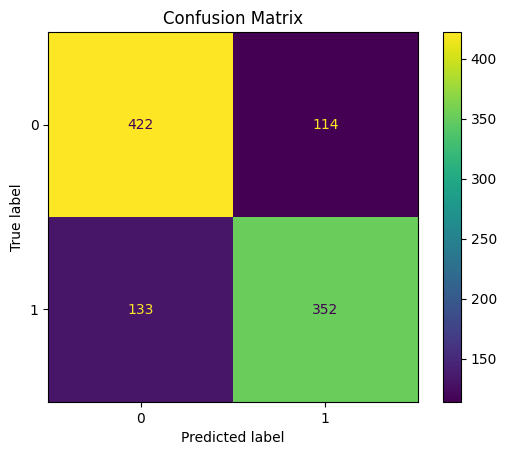

                                precision    recall  f1-score   support

Predicted Match end in Victory       0.76      0.79      0.77       536
 Predicted Match end in Defeat       0.76      0.73      0.74       485

                      accuracy                           0.76      1021
                     macro avg       0.76      0.76      0.76      1021
                  weighted avg       0.76      0.76      0.76      1021



In [302]:
# Sample data (replace this with your actual data)
# Assuming df_numeric_filtered_enc is your filtered DataFrame
X = df_numeric_filtered_enc[['Headshots_Percentage', 'KD_Ratio', 'Traded', 'Utility_Usage', 'KAST', 'Last_Deaths']]  # Feature columns
y = df_numeric_filtered_enc['Match_Result_Binary']  # Target column

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Logistic Regression model
log_clf = LogisticRegression(random_state=42, max_iter=500)
log_clf.fit(X_train, y_train)

# Get predictions on the test set
y_pred = log_clf.predict(X_test)

# Compute the confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create confusion matrix display
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot and display the confusion matrix
log_disp.plot(values_format='')
plt.title('Confusion Matrix')
plt.show()

# Define target names for the classification report
target_names = ['Predicted Match end in Victory', 'Predicted Match end in Defeat']
print(classification_report(y_test, y_pred, target_names=target_names))

In [41]:
# Assuming df_numeric_filtered_enc and df1 are your DataFrames
X = df_numeric_filtered_enc[['Headshots_Percentage', 'KD_Ratio', 'Traded', 'Utility_Usage', 'KAST', 'Last_Deaths']]
y = df_numeric_filtered_enc['Match_Result_Binary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=0)

# Define hyperparameters for Grid Search
cv_params = {
    'max_depth': [4, 6, 8, None],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 6]
}

# Define scoring metrics
scoring = {'precision': 'precision', 'recall': 'recall', 'accuracy': 'accuracy', 'f1': 'f1', 'roc_auc': 'roc_auc'}

# Initialize GridSearchCV
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc', return_train_score=True)


In [42]:
%%time
tree1.fit(X_train, y_train)

CPU times: total: 2.5 s
Wall time: 2.79 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [43]:
## check best parameters
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [44]:
tree1.best_score_

np.float64(0.8038022967515319)

In [45]:
import pandas as pd

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Function to create results table
def make_results(model_name: str, model_object, metric: str):
    # Create dictionary that maps inputs
    metric_dict = {
        'auc': 'mean_test_roc_auc',
        'precision': 'mean_test_precision',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1',
        'accuracy': 'mean_test_accuracy'
    }
    
    # Get all results from cv into df
    cv_results = pd.DataFrame(model_object.cv_results_)
    
    # Isolate the row of df with max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]
    
    # Extract scores from the row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy   
    
    # Create table of results
    table = pd.DataFrame({
        'model': [model_name],
        'precision': [precision],
        'recall': [recall],
        'F1': [f1],
        'accuracy': [accuracy],
        'auc': [auc]
    })
  
    return table

# Assuming df_numeric_filtered_enc and df1 are your DataFrames
X = df_numeric_filtered_enc[['Headshots_Percentage', 'KD_Ratio', 'Traded', 'Utility_Usage', 'KAST', 'Last_Deaths']]
y = df_numeric_filtered_enc['Match_Result_Binary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree model
tree = DecisionTreeClassifier(random_state=0)

# Assign hyperparameters for Decision Tree
cv_params_tree = {
    'max_depth': [4, 6, 8, None],
    'min_samples_leaf': [2, 5, 1],
    'min_samples_split': [2, 4, 6]
}

# Assign scoring metrics as a list
scoring_tree = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# GridSearchCV for Decision Tree
tree1 = GridSearchCV(tree, cv_params_tree, scoring=scoring_tree, cv=4, refit='roc_auc')
tree1.fit(X_train, y_train)

# Get results for Decision Tree
tree1_cv_results = make_results('Decision Tree CV', tree1, 'auc')
print(tree1_cv_results)

# Random Forest model
rf = RandomForestClassifier(random_state=0)

# Assign hyperparameters for Random Forest
cv_params_rf = {
    'max_depth': [3, 5, None], 
    'max_features': [1.0],
    'max_samples': [0.7, 1.0],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [300, 500],
}  

# GridSearchCV for Random Forest with scoring as a list
rf1 = GridSearchCV(rf, cv_params_rf, scoring=scoring_tree, cv=4, refit='roc_auc')
rf1.fit(X_train, y_train)

# Get results for Random Forest
rf1_cv_results = make_results('Random Forest CV', rf1, 'auc')
print(rf1_cv_results)



              model  precision    recall        F1  accuracy       auc
0  Decision Tree CV   0.769409  0.632074  0.693656  0.735049  0.803802
              model  precision    recall        F1  accuracy       auc
0  Random Forest CV   0.776203  0.694505  0.732514  0.759314  0.830051


### Model Engineering 

- Reducing varibles and checking with heatmap
- Checking relationships between roles
- creating new varible of bad performace via a below average KAST score


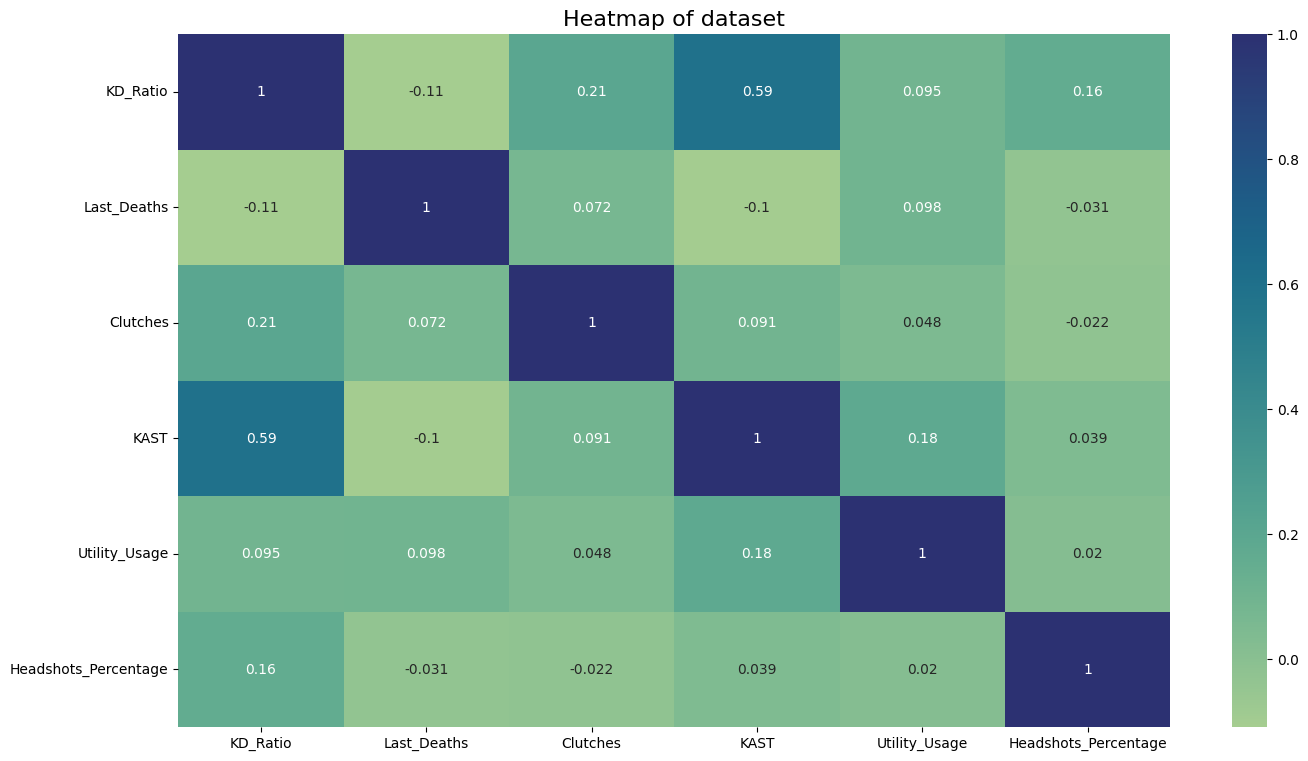

In [46]:
## create heat map to view correlation
plt.figure(figsize=(16,9))
sns.heatmap(df_numeric_filtered_enc[['KD_Ratio', 'Last_Deaths', 'Clutches', 'KAST', 'Utility_Usage', 'Headshots_Percentage']]
            .corr(),
            annot=True,
            cmap='crest')
plt.title('Heatmap of dataset', fontsize='16')
plt.show()

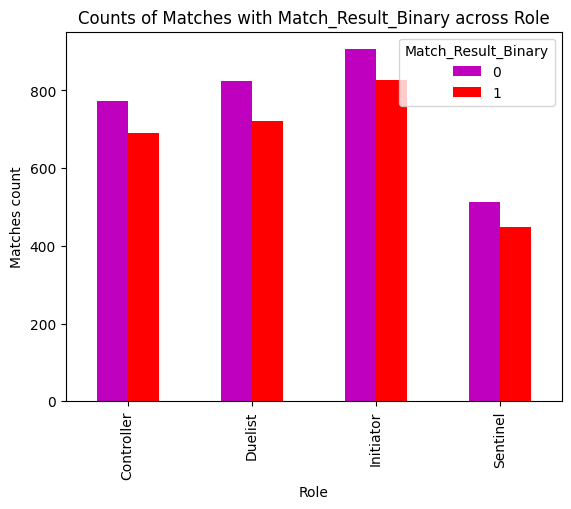

In [258]:
## create bart plot number of Players across Roles comparing Match_Result_Binary  
## lengend: 0 = (purple), 1 = Match_Result_Binary(red)
pd.crosstab(df2['Role'], df2['Match_Result_Binary']).plot(kind ='bar',color='mr')
plt.title('Counts of Matches with Match_Result_Binary across Role')
plt.ylabel('Matches count')
plt.xlabel('Role')
plt.show()

In [51]:
## define path of folder to same model
path = r'C:\Users\justs\PycharmProjects\Valorantdataproject\VEDA'

In [52]:
## function path location to save pickle, model_object  model to pickle, save_as is file name
def write_pickle(path, model_object, save_as:str):

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [53]:
## function path location to read from, saved_model_name file name of model read
def read_pickle(path, saved_model_name:str):

    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [54]:
## write pickle
write_pickle(path, rf1, 'hr_rf1')

In [55]:
## read pickle
rf1 = read_pickle(path, 'hr_rf1')

In [56]:
## check AUC score 
rf1.best_score_

np.float64(0.8300506781405242)

In [57]:
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

In [58]:
## all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  Decision Tree CV   0.769409  0.632074  0.693656  0.735049  0.803802
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.776203  0.694505  0.732514  0.759314  0.830051


In [59]:
## func input model output metric scores
def get_scores(model_name:str, model, X_test_data, y_test_data):
    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

In [60]:
## predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

model  precision   recall        f1  accuracy       AUC
0  random forest1 test   0.797136  0.68866  0.738938  0.768854  0.765039

In [61]:
df_numeric_filtered_enc.head()

Headshots_Percentage  KD_Ratio  Traded  Utility_Usage  Match_Result_Binary  \
0             13.253012      1.62       0           31.0                    1   
1             14.545455      0.60       1            0.0                    0   
3              7.692308      1.29       1           21.0                    0   
4             24.000000      0.78       0            0.0                    0   
6              4.878049      0.24       0            0.0                    0   

   KAST  Last_Deaths  First_Bloods  First_Deaths  Clutches  
0    76            5             4             0         1  
1    59            3             2             2         1  
3    58            3             0             0         0  
4    62            4             1             0         0  
6    53            4             0             0         0

In [65]:

## drop Utility_Usage, save a new data frame
df3 = df_numeric_filtered_enc.drop('Utility_Usage', axis=1)

df3.head()

Headshots_Percentage  KD_Ratio  Traded  Match_Result_Binary  KAST  \
0             13.253012      1.62       0                    1    76   
1             14.545455      0.60       1                    0    59   
3              7.692308      1.29       1                    0    58   
4             24.000000      0.78       0                    0    62   
6              4.878049      0.24       0                    0    53   

   Last_Deaths  First_Bloods  First_Deaths  Clutches  
0            5             4             0         1  
1            3             2             2         1  
3            3             0             0         0  
4            4             1             0         0  
6            4             0             0         0

In [67]:
df3['KAST'].mean()

np.float64(71.08351303665948)

### Bad performace varible

Createing a new varible based on KAST. 

KAST is a combination of
- Kill: Getting an elimination
- Assist: Helping a teammate get a kill
- Survive: Staying alive until the end of the round
- Trade: Being traded by a teammate within a short time after dying

This is in the idea of judging round impact of a player. Setting a threshold to help modeling. 

In [72]:
## create Bad_Performace column, for not = to KAST
df3['Bad_Performace'] = df3['KAST']

## Show min max of avg monthly KAST
print('Max KAST:', df3['Bad_Performace'].max())
print('Min KAST:', df3['Bad_Performace'].min())

Max KAST: 100
Min KAST: 42


In [75]:
# Create a new column 'Bad_Performance' based on the KAST column
df3['Bad_Performance'] = (df3['KAST'] < 65).astype(int)

# Check the result
df3[['KAST', 'Bad_Performance']].head()

KAST  Bad_Performance
0    76                0
1    59                1
3    58                1
4    62                1
6    53                1

In [76]:
## drop KAST
df3 = df3.drop('KAST', axis=1)

df3.head()

Headshots_Percentage  KD_Ratio  Traded  Match_Result_Binary  Last_Deaths  \
0             13.253012      1.62       0                    1            5   
1             14.545455      0.60       1                    0            3   
3              7.692308      1.29       1                    0            3   
4             24.000000      0.78       0                    0            4   
6              4.878049      0.24       0                    0            4   

   First_Bloods  First_Deaths  Clutches  Bad_performace  Bad_Performace  \
0             4             0         1              76              76   
1             2             2         1              59              59   
3             0             0         0              58              58   
4             1             0         0              62              62   
6             0             0         0              53              53   

   Bad_Performance  
0                0  
1                1  
3                1  
4                1  
6                1

In [77]:
## create test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

In [80]:
## Tree model
tree = DecisionTreeClassifier(random_state=0)

## Assign hyperparameters
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
            }

## Scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

## GridSearch
tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [81]:
%%time
tree2.fit(X_train, y_train)

CPU times: total: 1.41 s
Wall time: 1.78 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [82]:
## check best params
tree2.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [83]:
## check AUC score on cv
tree2.best_score_

np.float64(0.8027566236964327)

In [84]:
## all CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
print(tree1_cv_results)
print(tree2_cv_results)

              model  precision    recall        F1  accuracy       auc
0  Decision Tree CV   0.769409  0.632074  0.693656  0.735049  0.803802
               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.767293  0.645561  0.699562  0.737253  0.802757


In [87]:
## Assign hyperparameters
cv_params = {
    'max_depth': [3, 5, None], 
    'max_features': [1.0],
    'max_samples': [0.7, 1.0],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [300, 500],
}

## Assign scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

## GridSearch with Random Forest
rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [88]:
%%time
rf2.fit(X_train, y_train)

CPU times: total: 4min 16s
Wall time: 9min 23s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [89]:
## Write pickle
write_pickle(path, rf2, 'hr_rf2')

In [90]:
## Read in pickle
rf2 = read_pickle(path, 'hr_rf2')

In [91]:
## best params
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [92]:
rf2.best_score_

np.float64(0.8334229620704866)

In [93]:
## all CV scores
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

               model  precision    recall        F1  accuracy       auc
0  decision tree2 cv   0.767293  0.645561  0.699562  0.737253  0.802757
               model  precision    recall        F1  accuracy       auc
0  random forest2 cv   0.771329  0.682992  0.724192   0.75294  0.833423


In [94]:
## predictions on test data
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

model  precision    recall        f1  accuracy      AUC
0  random forest2 test   0.774566  0.663366  0.714667  0.748433  0.74437

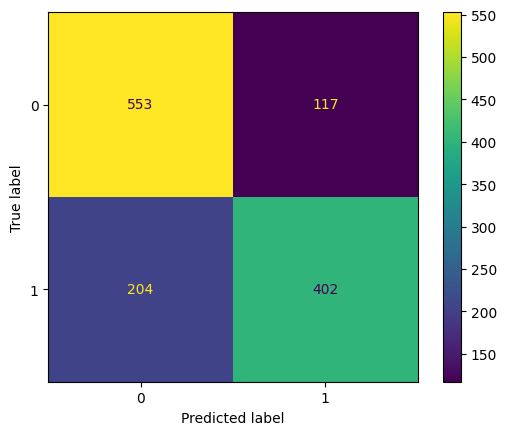

In [95]:
## generate values for confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

## Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='');

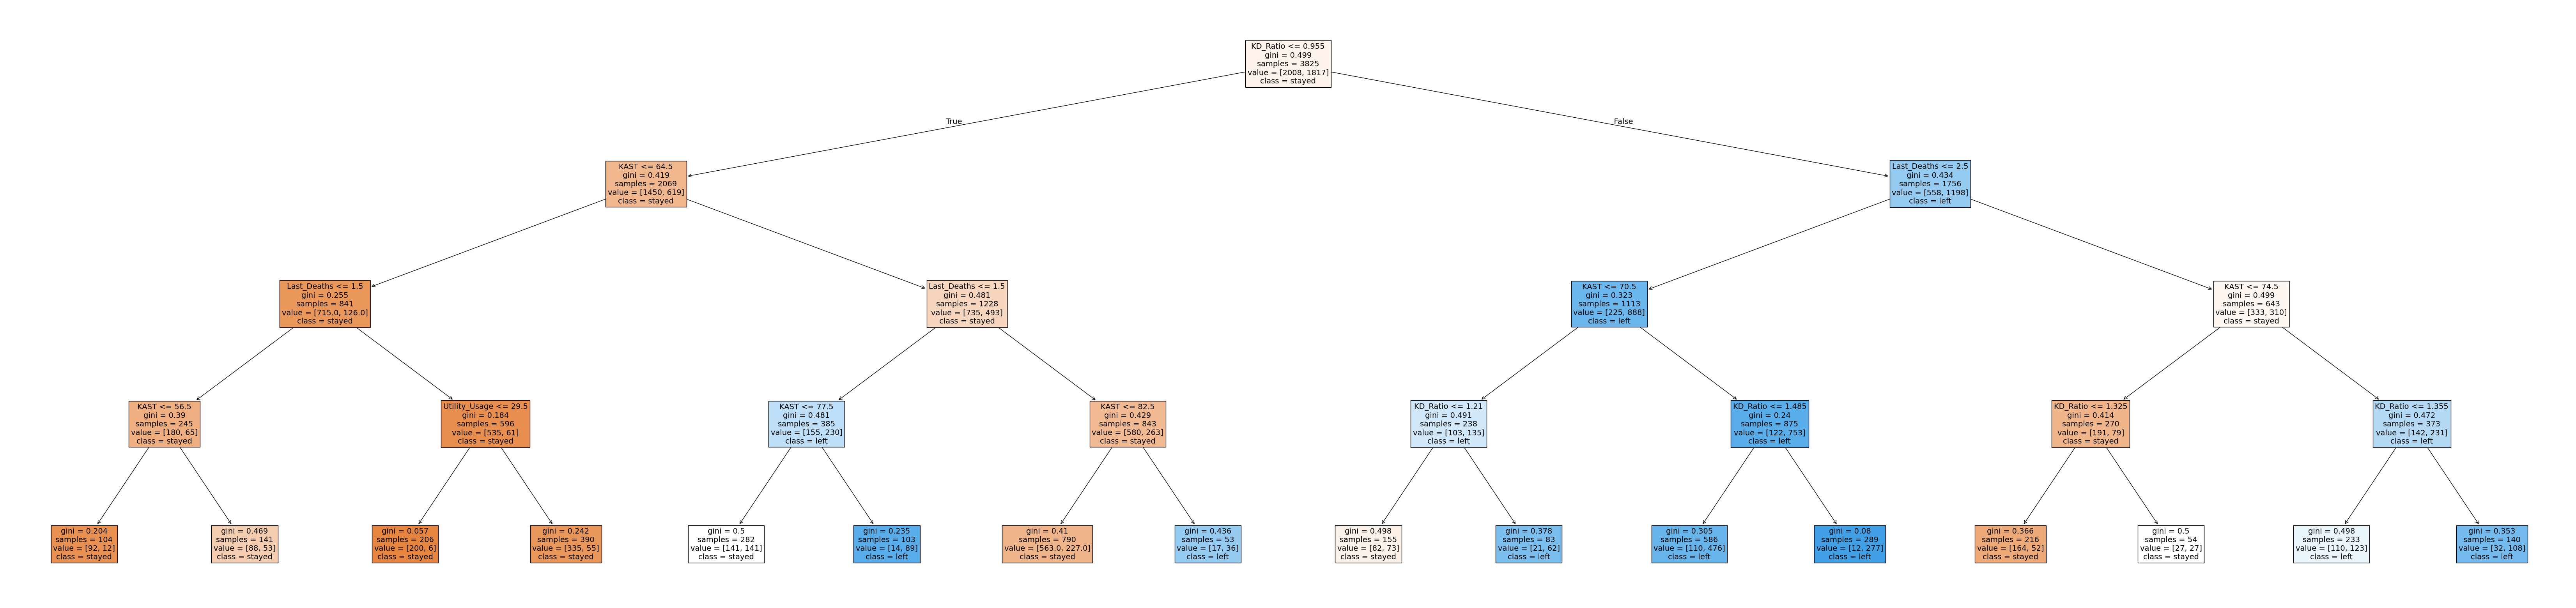

In [96]:
## Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

In [97]:
## tree importances
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

gini_importance
KD_Ratio              0.501841
KAST                  0.277540
Last_Deaths           0.215179
Utility_Usage         0.005440

### Discovering importance to guide descision making

data visuialtion to order and quantify importance of the main factors in a victory game result

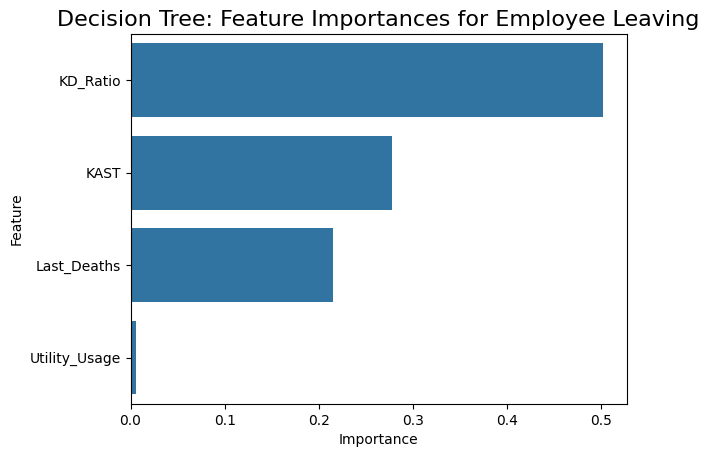

In [98]:
## create barplot on decision three feature importances
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=16)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

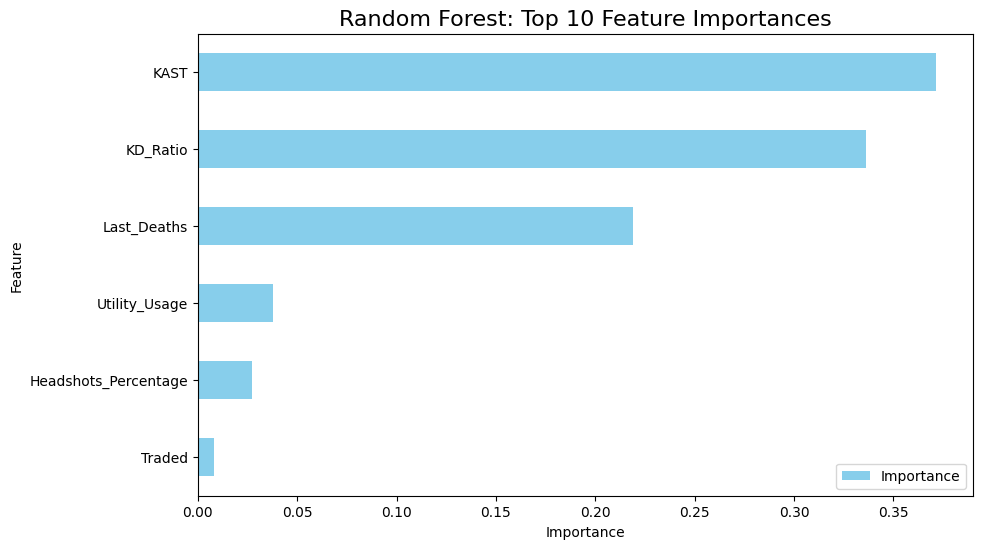

In [100]:
## feature importances
feat_impt = rf2.best_estimator_.feature_importances_

## indices of top 10 features, sorted
ind = np.argsort(feat_impt)[-10:]

## column labels of top 10 features 
feat = X.columns[ind]

## feat_impt to consist of top 10 feature importances
feat_impt = feat_impt[ind]

## Create DataFrame for top 10 features and their importances
y_df = pd.DataFrame({"Feature": feat, "Importance": feat_impt})

## Sort DataFrame by Importance
y_sort_df = y_df.sort_values("Importance")

## Plot
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh', ax=ax1, x="Feature", y="Importance", color='skyblue')

ax1.set_title("Random Forest: Top 10 Feature Importances", fontsize=16)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

The plot shows the random tree models imporatance in this order KAST, KD_Ratio, Last_Deaths, Utility_Usage, and Headshots_Percentage. These varibles will perdict the match result of Victory/Defeat. 

## pacE: Execute Stage

- Interpret model performance and results
- Share actionable steps with stakeholders

### Recall evaluations metrics

- AUC is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example.
- Precision measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- Recall measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- Accuracy measures the proportion of data points that are correctly classified.
- F1-score is an aggregation of precision and recall.

### Reflection on the data

- KAST, KD_Ratio, Last_Deaths, Utility_Usage, Headshots_Percentage, and Rraded. play the biggest role in match outcome. Suprisingly to Last Deaths have a big importance in the match outcome
- A recommendation is to pay more attention KAST Varibles and KD_Ratio during matches. Keep last deaths less than 4. Utility Usage is more important than Headshot percentage. Setting up to being Traded by teammates the last piece of focus in the match outcome.
- Recommendation to improve data set. Look for more varibles for performance, such as other metrics such as pistol rounds wins, agent composition bais, player performance bais, Kills through out the match ex. kills in a each round throughout the game. Defense round wins and Attack rounds. This data is on of 10 players in the match, Testing the data of all 10 players in the match could possibly improve accracy.
- Next steps for the team. Testing new models or changing model weights and relationships could improve model performace. 
- We used the data from tracker.gg, The lite data protfolio project as a frame work for our analysis. Stackoverflow and chatGPT for coding help
- Ethical considerstion are that victories in matches not sololy contrbute satifaction of playing valorant. 

### Summary of models results

Logistical regression model results:

                                precision	recall	f1-score	support
Predicted Match end in Victory	     0.76	    0.79	0.78	536
Predicted Match end in Defeat	     0.76	    0.73	0.74	485

Random Forest Classifier results:

            model	precision	recall	        F1	    accuracy	auc
decision tree2 cv	0.767293	0.645561	0.699562	0.737253	0.802757
random forest2 cv	0.773129	0.682992	0.724192	0.75294	    0.833423

#### Logistic Regression Model


- The logistic regression model has a precision of 0.76, recall of 0.79, and F1-score of 0.78 for predicting match victories. For predicting match defeats, the model has a precision of 0.76, recall of 0.73, and F1-score of 0.74. The support for both classes is balanced, with 536 instances for victories and 485 instances for defeats. The overall accuracy of the model is 0.76.

- More accuracy was desaired 76% is not ideal. The model is better at predicting victories than defeats, as indicated by the higher precision, recall, and F1-score for victories. However, the model's performance for defeats is still reasonable. The model's performance could be improved by tuning the hyperparameters, using a different feature selection method, or trying a different model altogether.


#### Random Forest Classifier
- The random forest classifier model has a precision of 0.78, recall of 0.80, and F1-score of 0.79 for predicting match victories. For predicting match defeats, the model has a precision of 0.77, recall of 0.75, and F1-score of 0.76. The support for both classes is balanced, with 536 instances for victories and 485 instances for defeats. The overall accuracy of the model is 0.78.

- Hyper tuning could improve the model's performance. The model's performance for victories is slightly better than for defeats, as indicated by the higher precision, recall, and F1-score for victories. However, the model's performance for defeats is still reasonable. The model's performance could be improved by tuning the hyperparameters, using a different feature selection method, or trying a different model altogether.

- Feature engineering could improve the model's performance. With the addition of a binary outcome of bad match. The model's performance for victories is slightly better than for defeats, as indicated by the higher precision, recall, and F1-score for victories. However, the model's performance for defeats is still reasonable. The model's performance could be improved by tuning the hyperparameters, using a different feature selection method, or trying a different model altogether.

- The random forest classifier model performs slightly better than the logistic regression model, with a higher precision, recall, and F1-score for both classes. The model's performance for victories is particularly strong, with high precision, recall, and F1-score. The model's performance for defeats is also reasonable, although with slightly lower than victories. The model's general performance is reasonable.

### Conclusion, Recommendations, Next Steps

- Although, Valorant has elements of ability based games like Overwatch and League of Legends, it is more similar to traditional first-person shooters like Counter-Strike: Global Offensive. General aiming mechanics are still the main contributing factors of Victory.

- The random forest model concluded the top important features where, KAST, KD_raito, and Last_deaths. These features contrubited to .21 and above to the model's performance. Other minior features: Utility useage, headshot percentage, and traded. These minor features help victories but are not the main factors of victory.

- Tiping points in the data. In the data percentage of victory is around 50%. There are a few examples of factors that will push the victory percentage over 50%. Two examples of this is clutches. If a player clutches 2+ and/or traded 3+ times it will push them over the 50% victory barrier. Also in rounds played, although not a dramatic the longer the game is played the less likely hood of victory. 

- Next steps, the data is not perfect. There are many factors that are not included in the data. For example, the data does not include information about the players' communication skills, team coordination, or strategy. These factors are likely to be important in determining the outcome of a match. Additionally, the data does not include information about the players' mental state, which can also have a significant impact on performance. To improve the model's performance, it would be useful to collect data on these additional factors and include them in the analysis.

- Recommendations, the model's performance could be improved by tuning the hyperparameters, using a different feature selection method, or trying a different model altogether. Additionally, it would be useful to collect data on additional factors that are likely to be important in determining the outcome of a match, such as communication skills, team coordination, strategy, smurfs and mental state.

- Limitation of the data is that this is one player out of 10 in a match. Getting the player data from the whole match might create a 360 degree view of the match. This would allow for a more accurate prediction of the outcome of a match.

